# Linear regression with Eustatic Sea-level data

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a polynomial function to Eustatic Sea-level heights.

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

---

Data set is from "Sea level and global ice volumes from the Last Glacial Maximum to the Holocene"
K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi

Remember to uncomment and run the code cell below as well, as we are going to
load some data from GitHub.

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Linear regression

Lets start with some (x,y) data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#
def load_data_xy(filename):

    f = open(filename, 'r')
    header = f.readline()
    lines = f.readlines()

    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    for line in lines:
        columns = line.split()
        x = np.append(x,float(columns[0]))
        y = np.append(y,float(columns[1]))
        sx = np.append(sx,float(columns[2])/2.0)
        sy = np.append(sy,float(columns[3])/2.0)

    d = x,y, sy                                   # Combine into a single data structure

    return d

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [5]:
data_x,data_y,sy = load_data_xy("ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [6]:
maxtime = 20.
ndata = np.where(data_x>maxtime)[0][0]

In [7]:
data_x,data_y,sy = data_x[:ndata],data_y[:ndata],sy[:ndata]

And now lets plot the data.

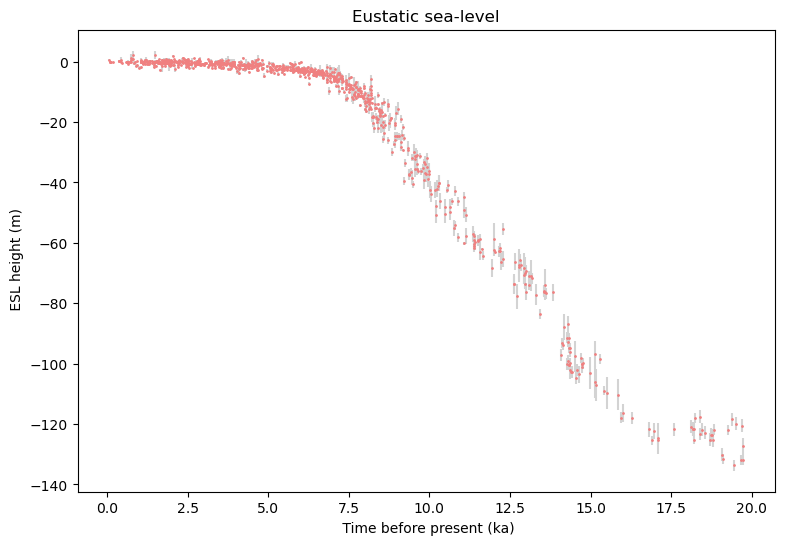

In [8]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)
plot_data(title='Eustatic sea-level')

## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem the forward operator takes the following form:

$$ \left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2$);
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).



We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [9]:
nparams = 5 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sy):
    factor= 10                                   # factor to inflate observational errors
    return np.diag(1./sy*1./sy)/(factor**2)

Define a reference model for later.

In [10]:
# Reference model for plotting
ESLref = load_data_ref("ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [11]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

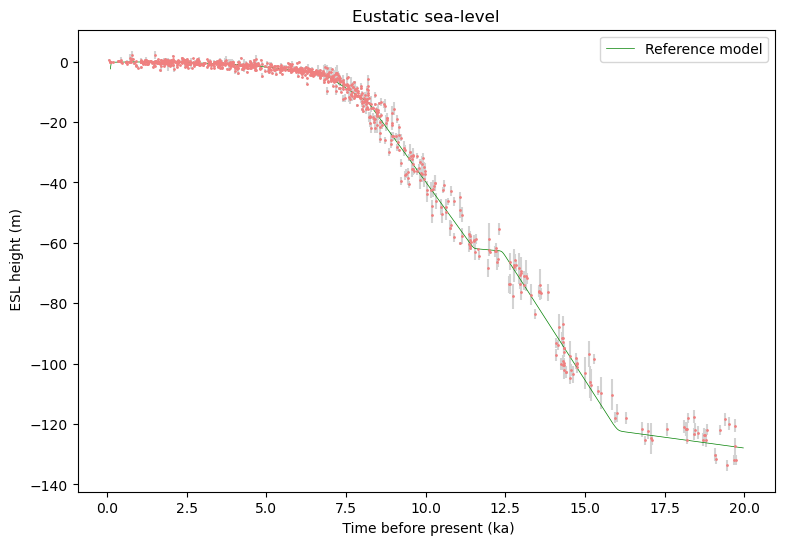

In [12]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

## 1. Linear system solver

In [13]:
from cofi import BaseProblem, InversionOptions, Inversion

### Step 1. Define CoFI `BaseProblem`

In [14]:
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

### Step 2. Define CoFI `InversionOptions`

In [15]:
inv_options = InversionOptions()

Using the information supplied, we can ask CoFI to suggest some solving methods.

In [16]:
inv_options.suggest_solving_methods()

The following solving methods are supported:
{'sampling', 'optimization', 'matrix solvers'}

Use `suggest_tools()` to see a full list of backend tools for each method


We can ask CoFI to suggest some specific software tools as well. 

In [17]:
inv_options.suggest_tools()

Here's a complete list of inversion tools supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee"
    ]
}


In [18]:
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'> (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [19]:
# below is optional, as this has already been the default tool under "linear least square"
inv_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case 
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution 

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

Lets run CoFI.

In [20]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [21]:
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]

Summary for inversion result
SUCCESS
----------------------------
model: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]
sum_of_squared_residuals: []
effective_rank: 5
singular_values: [1.72339368e+09 1.35569994e+06 3.54123758e+03 1.10384400e+02
 7.16903392e+00]
model_covariance: [[ 6.70145209e-02 -6.28173834e-02  1.67266578e-02 -1.60867740e-03
   4.77025592e-05]
 [-6.28173834e-02  7.43365995e-02 -2.23488563e-02  2.32179303e-03
  -7.20214235e-05]
 [ 1.67266578e-02 -2.23488563e-02  7.38371078e-03 -8.20763652e-04
   2.65025504e-05]
 [-1.60867740e-03  2.32179303e-03 -8.20763652e-04  9.62437921e-05
  -3.21300646e-06]
 [ 4.77025592e-05 -7.20214235e-05  2.65025504e-05 -3.21300646e-06
   1.10114955e-07]]


Lets plot the solution.

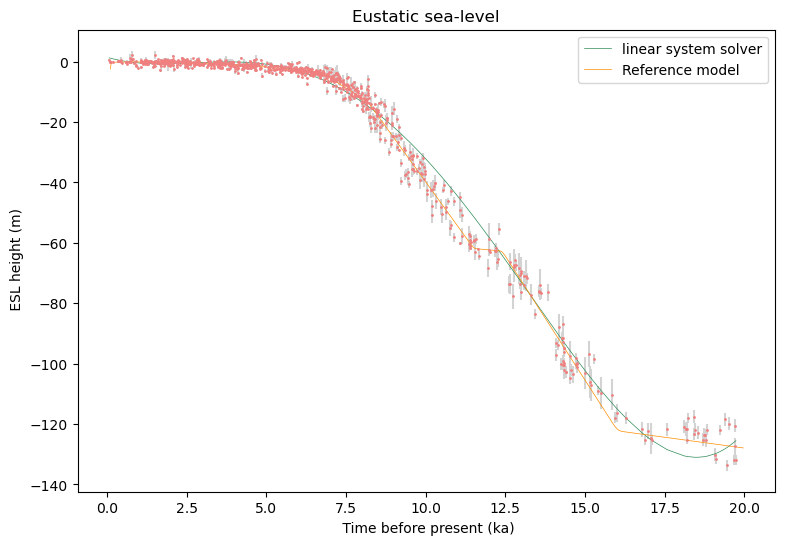

In [22]:
plot_data(title="Eustatic sea-level")
plot_model(data_x,jacobian(data_x).dot(inv_result.model), "linear system solver", color="seagreen")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where 
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularisation. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [23]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_initial_model(np.ones(nparams))
#inv_problem.set_initial_model(inv_result.model)
inv_problem.set_forward(forward)
inv_problem.set_data_misfit("squared error")

# inv_problem.set_objective(your_own_misfit_function)    # (optionally) if you'd like to define your own misfit
# inv_problem.set_gradient(your_own_gradient_of_misfit_function)    # (optionally) if you'd like to define your own misfit gradient

######## CoFI InversionOptions - set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")
inv_options_2.set_params(method="Nelder-Mead")

######## CoFI Inversion - run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]

Summary for inversion result
FAILURE
----------------------------
fun: 396.30180936007037
nit: 598
nfev: 1000
status: 1
message: Maximum number of function evaluations has been exceeded.
final_simplex: (array([[ 4.02211771, -7.6352002 ,  3.47983694, -0.52237961,  0.02043681],
       [ 4.02227491, -7.63498804,  3.47977907, -0.52238912,  0.02043829],
       [ 4.02218792, -7.63507241,  3.47979137, -0.5223722 ,  0.02043577],
       [ 4.02245903, -7.63488993,  3.47966829, -0.52235893,  0.02043602],
       [ 4.02257488, -7.63525136,  3.47962954, -0.52233062,  0.02043424],
       [ 4.02215782, -7.63502984,  3.47981924, -0.5223883 ,  0.02043736]]), array([396.30180936, 396.30181593, 396.30181983, 396.30182837,
       396.30183836, 396.30184074]))
model: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]


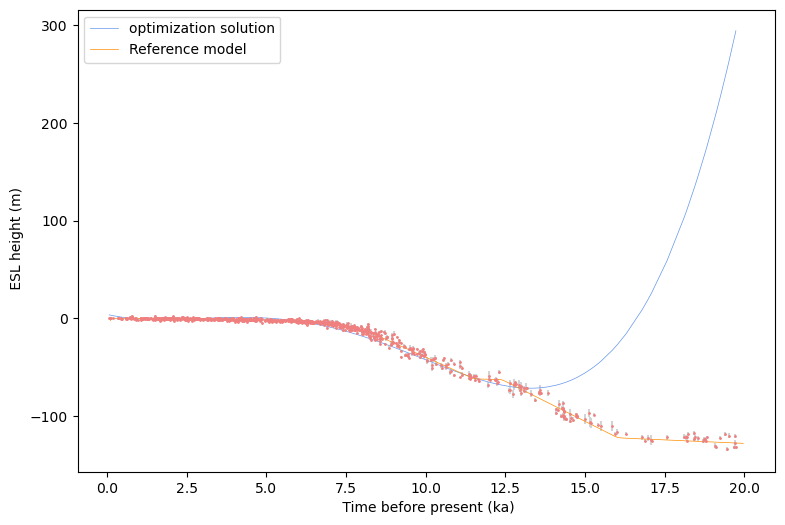

In [24]:
plot_data()
plot_model(data_x,jacobian(data_x).dot(inv_result_2.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

The optimization fails to convergence for this problem (with default settings). 

-------

### Challenge - Change the polynomial degree

Try and replace the 3rd order polynomial with a 2nd order polynomial (i.e. $M=2$) by adding the required commands below. What does the plot looks like? 

Start from code below:

```
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=<CHANGE ME>))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = <CHANGE ME> ")
plot_data()
plot_model(data_x,jacobian(x,n=<CHANGE ME>).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

```


In [25]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 3 


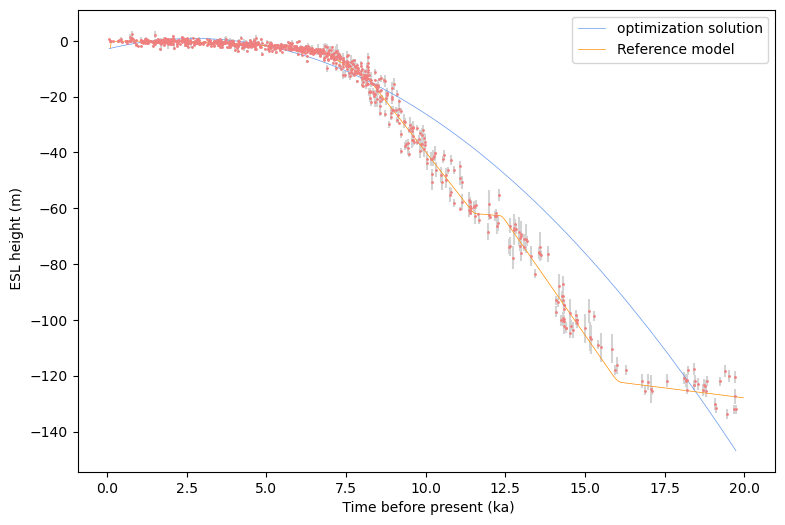

In [26]:
#@title Solution

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=3))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = 3 ")
plot_data()
plot_model(data_x,jacobian(data_x,n=3).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

Changing to a second order polynomial does converge but gives a poor fit.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

Here we artificially increase the observational errors on the data so that the spread of the posterior samples are visible.

In [27]:
Cdinv = Cd_inv()                 # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [28]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [29]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Add the information and run with CoFI

In [30]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## CoFI InversionOptions - get a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True, initial_state=walkers_start)

######## CoFI Inversion - run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

  0%|                                                                                                                                                                                                                                                                           | 0/10000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                                                                                                                  | 8/10000 [00:00<02:21, 70.75it/s]

  0%|▌                                                                                                                                                                                                                                                                 | 20/10000 [00:00<01:43, 95.98it/s]

  0%|▊                                                                                                                                                                                                                                                                | 34/10000 [00:00<01:27, 113.38it/s]

  0%|█▏                                                                                                                                                                                                                                                               | 48/10000 [00:00<01:21, 122.78it/s]

  1%|█▌                                                                                                                                                                                                                                                               | 62/10000 [00:00<01:17, 128.27it/s]

  1%|█▉                                                                                                                                                                                                                                                               | 76/10000 [00:00<01:15, 131.23it/s]

  1%|██▎                                                                                                                                                                                                                                                              | 90/10000 [00:00<01:14, 133.45it/s]

  1%|██▋                                                                                                                                                                                                                                                             | 104/10000 [00:00<01:13, 134.69it/s]

  1%|███                                                                                                                                                                                                                                                             | 118/10000 [00:00<01:12, 135.66it/s]

  1%|███▍                                                                                                                                                                                                                                                            | 132/10000 [00:01<01:12, 136.43it/s]

  1%|███▋                                                                                                                                                                                                                                                            | 146/10000 [00:01<01:12, 136.82it/s]

  2%|████                                                                                                                                                                                                                                                            | 160/10000 [00:01<01:11, 137.15it/s]

  2%|████▍                                                                                                                                                                                                                                                           | 174/10000 [00:01<01:11, 136.81it/s]

  2%|████▊                                                                                                                                                                                                                                                           | 188/10000 [00:01<01:11, 136.62it/s]

  2%|█████▏                                                                                                                                                                                                                                                          | 202/10000 [00:01<01:12, 135.17it/s]

  2%|█████▌                                                                                                                                                                                                                                                          | 216/10000 [00:01<01:11, 135.89it/s]

  2%|█████▉                                                                                                                                                                                                                                                          | 230/10000 [00:01<01:11, 136.57it/s]

  2%|██████▏                                                                                                                                                                                                                                                         | 244/10000 [00:01<01:11, 136.96it/s]

  3%|██████▌                                                                                                                                                                                                                                                         | 258/10000 [00:01<01:11, 136.84it/s]

  3%|██████▉                                                                                                                                                                                                                                                         | 272/10000 [00:02<01:11, 136.65it/s]

  3%|███████▎                                                                                                                                                                                                                                                        | 286/10000 [00:02<01:10, 137.19it/s]

  3%|███████▋                                                                                                                                                                                                                                                        | 300/10000 [00:02<01:10, 137.53it/s]

  3%|████████                                                                                                                                                                                                                                                        | 314/10000 [00:02<01:11, 135.11it/s]

  3%|████████▍                                                                                                                                                                                                                                                       | 328/10000 [00:02<01:11, 135.56it/s]

  3%|████████▊                                                                                                                                                                                                                                                       | 342/10000 [00:02<01:11, 135.70it/s]

  4%|█████████                                                                                                                                                                                                                                                       | 356/10000 [00:02<01:11, 135.83it/s]

  4%|█████████▍                                                                                                                                                                                                                                                      | 370/10000 [00:02<01:10, 135.99it/s]

  4%|█████████▊                                                                                                                                                                                                                                                      | 384/10000 [00:02<01:10, 136.10it/s]

  4%|██████████▏                                                                                                                                                                                                                                                     | 398/10000 [00:02<01:10, 136.18it/s]

  4%|██████████▌                                                                                                                                                                                                                                                     | 412/10000 [00:03<01:10, 135.42it/s]

  4%|██████████▉                                                                                                                                                                                                                                                     | 426/10000 [00:03<01:10, 135.11it/s]

  4%|███████████▎                                                                                                                                                                                                                                                    | 440/10000 [00:03<01:10, 135.01it/s]

  5%|███████████▌                                                                                                                                                                                                                                                    | 454/10000 [00:03<01:10, 135.36it/s]

  5%|███████████▉                                                                                                                                                                                                                                                    | 468/10000 [00:03<01:10, 136.04it/s]

  5%|████████████▎                                                                                                                                                                                                                                                   | 482/10000 [00:03<01:09, 136.73it/s]

  5%|████████████▋                                                                                                                                                                                                                                                   | 496/10000 [00:03<01:09, 136.33it/s]

  5%|█████████████                                                                                                                                                                                                                                                   | 510/10000 [00:03<01:09, 135.88it/s]

  5%|█████████████▍                                                                                                                                                                                                                                                  | 524/10000 [00:03<01:09, 136.48it/s]

  5%|█████████████▊                                                                                                                                                                                                                                                  | 538/10000 [00:04<01:09, 136.65it/s]

  6%|██████████████▏                                                                                                                                                                                                                                                 | 552/10000 [00:04<01:09, 136.00it/s]

  6%|██████████████▍                                                                                                                                                                                                                                                 | 566/10000 [00:04<01:09, 135.56it/s]

  6%|██████████████▊                                                                                                                                                                                                                                                 | 580/10000 [00:04<01:09, 135.50it/s]

  6%|███████████████▏                                                                                                                                                                                                                                                | 594/10000 [00:04<01:12, 130.20it/s]

  6%|███████████████▌                                                                                                                                                                                                                                                | 608/10000 [00:04<01:13, 127.71it/s]

  6%|███████████████▉                                                                                                                                                                                                                                                | 622/10000 [00:04<01:12, 129.51it/s]

  6%|████████████████▎                                                                                                                                                                                                                                               | 636/10000 [00:04<01:11, 131.66it/s]

  6%|████████████████▋                                                                                                                                                                                                                                               | 650/10000 [00:04<01:10, 133.12it/s]

  7%|████████████████▉                                                                                                                                                                                                                                               | 664/10000 [00:04<01:09, 134.34it/s]

  7%|█████████████████▎                                                                                                                                                                                                                                              | 678/10000 [00:05<01:08, 135.19it/s]

  7%|█████████████████▋                                                                                                                                                                                                                                              | 692/10000 [00:05<01:08, 135.87it/s]

  7%|██████████████████                                                                                                                                                                                                                                              | 706/10000 [00:05<01:08, 135.66it/s]

  7%|██████████████████▍                                                                                                                                                                                                                                             | 720/10000 [00:05<01:09, 134.20it/s]

  7%|██████████████████▊                                                                                                                                                                                                                                             | 734/10000 [00:05<01:08, 134.84it/s]

  7%|███████████████████▏                                                                                                                                                                                                                                            | 748/10000 [00:05<01:11, 128.78it/s]

  8%|███████████████████▌                                                                                                                                                                                                                                            | 762/10000 [00:05<01:11, 129.48it/s]

  8%|███████████████████▊                                                                                                                                                                                                                                            | 776/10000 [00:05<01:10, 131.28it/s]

  8%|████████████████████▏                                                                                                                                                                                                                                           | 790/10000 [00:05<01:09, 133.05it/s]

  8%|████████████████████▌                                                                                                                                                                                                                                           | 804/10000 [00:06<01:17, 118.68it/s]

  8%|████████████████████▉                                                                                                                                                                                                                                           | 817/10000 [00:06<01:18, 116.44it/s]

  8%|█████████████████████▎                                                                                                                                                                                                                                          | 831/10000 [00:06<01:15, 122.11it/s]

  8%|█████████████████████▌                                                                                                                                                                                                                                          | 844/10000 [00:06<01:13, 123.83it/s]

  9%|█████████████████████▉                                                                                                                                                                                                                                          | 857/10000 [00:06<01:21, 112.59it/s]

  9%|██████████████████████▎                                                                                                                                                                                                                                         | 870/10000 [00:06<01:18, 116.20it/s]

  9%|██████████████████████▋                                                                                                                                                                                                                                         | 884/10000 [00:06<01:15, 121.03it/s]

  9%|██████████████████████▉                                                                                                                                                                                                                                         | 897/10000 [00:06<01:13, 123.28it/s]

  9%|███████████████████████▎                                                                                                                                                                                                                                        | 910/10000 [00:06<01:12, 125.05it/s]

  9%|███████████████████████▋                                                                                                                                                                                                                                        | 923/10000 [00:07<01:12, 125.68it/s]

  9%|███████████████████████▉                                                                                                                                                                                                                                        | 936/10000 [00:07<01:19, 114.36it/s]

 10%|████████████████████████▎                                                                                                                                                                                                                                       | 950/10000 [00:07<01:15, 119.68it/s]

 10%|████████████████████████▋                                                                                                                                                                                                                                       | 964/10000 [00:07<01:12, 124.19it/s]

 10%|█████████████████████████                                                                                                                                                                                                                                       | 977/10000 [00:07<01:17, 116.62it/s]

 10%|█████████████████████████▎                                                                                                                                                                                                                                      | 991/10000 [00:07<01:13, 122.10it/s]

 10%|█████████████████████████▌                                                                                                                                                                                                                                     | 1004/10000 [00:07<01:13, 121.86it/s]

 10%|█████████████████████████▉                                                                                                                                                                                                                                     | 1018/10000 [00:07<01:11, 125.86it/s]

 10%|██████████████████████████▎                                                                                                                                                                                                                                    | 1032/10000 [00:07<01:10, 127.33it/s]

 10%|██████████████████████████▋                                                                                                                                                                                                                                    | 1046/10000 [00:08<01:08, 129.86it/s]

 11%|███████████████████████████                                                                                                                                                                                                                                    | 1060/10000 [00:08<01:07, 131.58it/s]

 11%|███████████████████████████▍                                                                                                                                                                                                                                   | 1074/10000 [00:08<01:07, 133.00it/s]

 11%|███████████████████████████▋                                                                                                                                                                                                                                   | 1088/10000 [00:08<01:06, 133.93it/s]

 11%|████████████████████████████                                                                                                                                                                                                                                   | 1102/10000 [00:08<01:06, 134.77it/s]

 11%|████████████████████████████▍                                                                                                                                                                                                                                  | 1116/10000 [00:08<01:05, 135.63it/s]

 11%|████████████████████████████▊                                                                                                                                                                                                                                  | 1130/10000 [00:08<01:05, 136.27it/s]

 11%|█████████████████████████████▏                                                                                                                                                                                                                                 | 1144/10000 [00:08<01:05, 135.84it/s]

 12%|█████████████████████████████▌                                                                                                                                                                                                                                 | 1158/10000 [00:08<01:05, 135.93it/s]

 12%|█████████████████████████████▉                                                                                                                                                                                                                                 | 1172/10000 [00:08<01:04, 135.89it/s]

 12%|██████████████████████████████▏                                                                                                                                                                                                                                | 1186/10000 [00:09<01:04, 135.74it/s]

 12%|██████████████████████████████▌                                                                                                                                                                                                                                | 1200/10000 [00:09<01:04, 135.68it/s]

 12%|██████████████████████████████▉                                                                                                                                                                                                                                | 1214/10000 [00:09<01:04, 135.69it/s]

 12%|███████████████████████████████▎                                                                                                                                                                                                                               | 1228/10000 [00:09<01:04, 135.77it/s]

 12%|███████████████████████████████▋                                                                                                                                                                                                                               | 1242/10000 [00:09<01:04, 135.75it/s]

 13%|████████████████████████████████                                                                                                                                                                                                                               | 1256/10000 [00:09<01:04, 136.18it/s]

 13%|████████████████████████████████▍                                                                                                                                                                                                                              | 1270/10000 [00:09<01:04, 134.51it/s]

 13%|████████████████████████████████▋                                                                                                                                                                                                                              | 1284/10000 [00:09<01:06, 131.36it/s]

 13%|█████████████████████████████████                                                                                                                                                                                                                              | 1298/10000 [00:09<01:05, 133.16it/s]

 13%|█████████████████████████████████▍                                                                                                                                                                                                                             | 1312/10000 [00:10<01:04, 133.94it/s]

 13%|█████████████████████████████████▊                                                                                                                                                                                                                             | 1326/10000 [00:10<01:04, 133.63it/s]

 13%|██████████████████████████████████▏                                                                                                                                                                                                                            | 1340/10000 [00:10<01:04, 134.31it/s]

 14%|██████████████████████████████████▌                                                                                                                                                                                                                            | 1354/10000 [00:10<01:04, 134.93it/s]

 14%|██████████████████████████████████▉                                                                                                                                                                                                                            | 1368/10000 [00:10<01:03, 135.15it/s]

 14%|███████████████████████████████████▏                                                                                                                                                                                                                           | 1382/10000 [00:10<01:04, 133.55it/s]

 14%|███████████████████████████████████▌                                                                                                                                                                                                                           | 1396/10000 [00:10<01:04, 134.30it/s]

 14%|███████████████████████████████████▉                                                                                                                                                                                                                           | 1410/10000 [00:10<01:03, 134.99it/s]

 14%|████████████████████████████████████▎                                                                                                                                                                                                                          | 1424/10000 [00:10<01:03, 135.31it/s]

 14%|████████████████████████████████████▋                                                                                                                                                                                                                          | 1438/10000 [00:10<01:03, 135.54it/s]

 15%|█████████████████████████████████████                                                                                                                                                                                                                          | 1452/10000 [00:11<01:02, 135.80it/s]

 15%|█████████████████████████████████████▍                                                                                                                                                                                                                         | 1466/10000 [00:11<01:02, 135.93it/s]

 15%|█████████████████████████████████████▋                                                                                                                                                                                                                         | 1480/10000 [00:11<01:02, 135.82it/s]

 15%|██████████████████████████████████████                                                                                                                                                                                                                         | 1494/10000 [00:11<01:02, 135.84it/s]

 15%|██████████████████████████████████████▍                                                                                                                                                                                                                        | 1508/10000 [00:11<01:10, 121.03it/s]

 15%|██████████████████████████████████████▊                                                                                                                                                                                                                        | 1521/10000 [00:11<01:09, 121.68it/s]

 15%|███████████████████████████████████████▏                                                                                                                                                                                                                       | 1535/10000 [00:11<01:07, 125.98it/s]

 15%|███████████████████████████████████████▍                                                                                                                                                                                                                       | 1549/10000 [00:11<01:05, 129.18it/s]

 16%|███████████████████████████████████████▊                                                                                                                                                                                                                       | 1563/10000 [00:11<01:04, 131.45it/s]

 16%|████████████████████████████████████████▏                                                                                                                                                                                                                      | 1577/10000 [00:12<01:05, 128.57it/s]

 16%|████████████████████████████████████████▌                                                                                                                                                                                                                      | 1591/10000 [00:12<01:04, 131.10it/s]

 16%|████████████████████████████████████████▉                                                                                                                                                                                                                      | 1605/10000 [00:12<01:04, 130.42it/s]

 16%|█████████████████████████████████████████▎                                                                                                                                                                                                                     | 1619/10000 [00:12<01:03, 132.15it/s]

 16%|█████████████████████████████████████████▋                                                                                                                                                                                                                     | 1633/10000 [00:12<01:06, 126.23it/s]

 16%|█████████████████████████████████████████▉                                                                                                                                                                                                                     | 1646/10000 [00:12<01:10, 118.78it/s]

 17%|██████████████████████████████████████████▎                                                                                                                                                                                                                    | 1660/10000 [00:12<01:07, 123.27it/s]

 17%|██████████████████████████████████████████▋                                                                                                                                                                                                                    | 1674/10000 [00:12<01:05, 127.32it/s]

 17%|███████████████████████████████████████████                                                                                                                                                                                                                    | 1688/10000 [00:12<01:04, 129.84it/s]

 17%|███████████████████████████████████████████▍                                                                                                                                                                                                                   | 1702/10000 [00:12<01:03, 131.68it/s]

 17%|███████████████████████████████████████████▊                                                                                                                                                                                                                   | 1716/10000 [00:13<01:02, 133.35it/s]

 17%|████████████████████████████████████████████                                                                                                                                                                                                                   | 1730/10000 [00:13<01:02, 132.76it/s]

 17%|████████████████████████████████████████████▍                                                                                                                                                                                                                  | 1744/10000 [00:13<01:01, 134.16it/s]

 18%|████████████████████████████████████████████▊                                                                                                                                                                                                                  | 1758/10000 [00:13<01:00, 135.21it/s]

 18%|█████████████████████████████████████████████▏                                                                                                                                                                                                                 | 1772/10000 [00:13<01:01, 133.77it/s]

 18%|█████████████████████████████████████████████▌                                                                                                                                                                                                                 | 1786/10000 [00:13<01:01, 133.15it/s]

 18%|█████████████████████████████████████████████▉                                                                                                                                                                                                                 | 1800/10000 [00:13<01:01, 133.67it/s]

 18%|██████████████████████████████████████████████▎                                                                                                                                                                                                                | 1814/10000 [00:13<01:01, 134.00it/s]

 18%|██████████████████████████████████████████████▌                                                                                                                                                                                                                | 1828/10000 [00:13<01:00, 134.17it/s]

 18%|██████████████████████████████████████████████▉                                                                                                                                                                                                                | 1842/10000 [00:14<01:00, 134.67it/s]

 19%|███████████████████████████████████████████████▎                                                                                                                                                                                                               | 1856/10000 [00:14<01:00, 135.04it/s]

 19%|███████████████████████████████████████████████▋                                                                                                                                                                                                               | 1870/10000 [00:14<00:59, 135.65it/s]

 19%|████████████████████████████████████████████████                                                                                                                                                                                                               | 1884/10000 [00:14<00:59, 136.19it/s]

 19%|████████████████████████████████████████████████▍                                                                                                                                                                                                              | 1898/10000 [00:14<00:59, 136.62it/s]

 19%|████████████████████████████████████████████████▊                                                                                                                                                                                                              | 1912/10000 [00:14<00:59, 136.81it/s]

 19%|█████████████████████████████████████████████████                                                                                                                                                                                                              | 1926/10000 [00:14<00:58, 136.92it/s]

 19%|█████████████████████████████████████████████████▍                                                                                                                                                                                                             | 1940/10000 [00:14<00:58, 136.93it/s]

 20%|█████████████████████████████████████████████████▊                                                                                                                                                                                                             | 1954/10000 [00:14<00:58, 136.74it/s]

 20%|██████████████████████████████████████████████████▏                                                                                                                                                                                                            | 1968/10000 [00:14<00:58, 136.72it/s]

 20%|██████████████████████████████████████████████████▌                                                                                                                                                                                                            | 1982/10000 [00:15<00:58, 137.22it/s]

 20%|██████████████████████████████████████████████████▉                                                                                                                                                                                                            | 1996/10000 [00:15<00:58, 137.28it/s]

 20%|███████████████████████████████████████████████████▎                                                                                                                                                                                                           | 2010/10000 [00:15<00:58, 136.51it/s]

 20%|███████████████████████████████████████████████████▌                                                                                                                                                                                                           | 2024/10000 [00:15<00:58, 136.64it/s]

 20%|███████████████████████████████████████████████████▉                                                                                                                                                                                                           | 2038/10000 [00:15<01:03, 125.76it/s]

 21%|████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 2052/10000 [00:15<01:01, 128.63it/s]

 21%|████████████████████████████████████████████████████▋                                                                                                                                                                                                          | 2066/10000 [00:15<01:00, 131.33it/s]

 21%|█████████████████████████████████████████████████████                                                                                                                                                                                                          | 2080/10000 [00:15<00:59, 132.40it/s]

 21%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                         | 2094/10000 [00:15<00:58, 134.05it/s]

 21%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                         | 2108/10000 [00:16<01:01, 129.38it/s]

 21%|██████████████████████████████████████████████████████                                                                                                                                                                                                         | 2122/10000 [00:16<01:01, 128.99it/s]

 21%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 2135/10000 [00:16<01:00, 129.16it/s]

 21%|██████████████████████████████████████████████████████▊                                                                                                                                                                                                        | 2149/10000 [00:16<00:59, 131.48it/s]

 22%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                       | 2163/10000 [00:16<00:58, 133.33it/s]

 22%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                       | 2177/10000 [00:16<00:58, 133.13it/s]

 22%|███████████████████████████████████████████████████████▊                                                                                                                                                                                                       | 2191/10000 [00:16<00:57, 134.71it/s]

 22%|████████████████████████████████████████████████████████▏                                                                                                                                                                                                      | 2205/10000 [00:16<00:57, 134.90it/s]

 22%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                      | 2219/10000 [00:16<00:57, 134.61it/s]

 22%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 2233/10000 [00:16<00:57, 134.80it/s]

 22%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 2247/10000 [00:17<01:02, 124.28it/s]

 23%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 2260/10000 [00:17<01:03, 122.00it/s]

 23%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                     | 2274/10000 [00:17<01:01, 125.63it/s]

 23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                    | 2288/10000 [00:17<00:59, 128.83it/s]

 23%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 2301/10000 [00:17<01:03, 121.01it/s]

 23%|███████████████████████████████████████████████████████████                                                                                                                                                                                                    | 2315/10000 [00:17<01:01, 125.28it/s]

 23%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 2328/10000 [00:17<01:01, 124.94it/s]

 23%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                                   | 2342/10000 [00:17<00:59, 128.06it/s]

 24%|████████████████████████████████████████████████████████████                                                                                                                                                                                                   | 2355/10000 [00:17<00:59, 128.28it/s]

 24%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 2369/10000 [00:18<00:58, 130.49it/s]

 24%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                                  | 2383/10000 [00:18<00:57, 132.07it/s]

 24%|█████████████████████████████████████████████████████████████                                                                                                                                                                                                  | 2397/10000 [00:18<00:57, 133.18it/s]

 24%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                 | 2411/10000 [00:18<00:56, 134.28it/s]

 24%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 2425/10000 [00:18<00:55, 135.49it/s]

 24%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 2439/10000 [00:18<00:55, 136.47it/s]

 25%|██████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 2453/10000 [00:18<00:55, 137.04it/s]

 25%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                                                | 2467/10000 [00:18<00:55, 136.86it/s]

 25%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 2481/10000 [00:18<00:54, 137.29it/s]

 25%|███████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 2495/10000 [00:18<00:54, 137.22it/s]

 25%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 2509/10000 [00:19<00:54, 136.91it/s]

 25%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 2523/10000 [00:19<00:54, 136.59it/s]

 25%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                                              | 2537/10000 [00:19<00:54, 136.33it/s]

 26%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 2551/10000 [00:19<00:54, 136.76it/s]

 26%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 2565/10000 [00:19<00:54, 136.92it/s]

 26%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 2579/10000 [00:19<00:54, 135.33it/s]

 26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                             | 2593/10000 [00:19<00:54, 136.08it/s]

 26%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                                                            | 2607/10000 [00:19<00:54, 136.47it/s]

 26%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 2621/10000 [00:19<01:00, 121.91it/s]

 26%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 2634/10000 [00:20<01:00, 121.94it/s]

 26%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                           | 2648/10000 [00:20<00:58, 124.95it/s]

 27%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 2662/10000 [00:20<00:57, 128.73it/s]

 27%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                          | 2676/10000 [00:20<00:59, 123.29it/s]

 27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 2689/10000 [00:20<00:59, 122.84it/s]

 27%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                          | 2703/10000 [00:20<00:57, 127.13it/s]

 27%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                         | 2717/10000 [00:20<00:56, 129.74it/s]

 27%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                         | 2731/10000 [00:20<00:54, 132.30it/s]

 27%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 2745/10000 [00:20<00:58, 125.05it/s]

 28%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 2758/10000 [00:21<00:58, 124.77it/s]

 28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                        | 2772/10000 [00:21<00:56, 127.88it/s]

 28%|███████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 2786/10000 [00:21<00:55, 129.83it/s]

 28%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                       | 2800/10000 [00:21<00:54, 131.66it/s]

 28%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                       | 2814/10000 [00:21<00:54, 132.58it/s]

 28%|████████████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 2828/10000 [00:21<00:53, 133.72it/s]

 28%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                      | 2842/10000 [00:21<00:53, 134.05it/s]

 29%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 2856/10000 [00:21<00:53, 134.73it/s]

 29%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                     | 2870/10000 [00:21<00:55, 127.63it/s]

 29%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 2884/10000 [00:21<00:54, 129.88it/s]

 29%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 2898/10000 [00:22<00:53, 131.89it/s]

 29%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                    | 2912/10000 [00:22<00:54, 128.88it/s]

 29%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                    | 2926/10000 [00:22<00:53, 131.46it/s]

 29%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 2940/10000 [00:22<00:53, 132.77it/s]

 30%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 2954/10000 [00:22<00:52, 134.25it/s]

 30%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 2968/10000 [00:22<00:52, 133.13it/s]

 30%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 2982/10000 [00:22<00:52, 134.56it/s]

 30%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 2996/10000 [00:22<00:54, 128.21it/s]

 30%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                  | 3010/10000 [00:22<00:53, 130.15it/s]

 30%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 3024/10000 [00:23<00:55, 125.45it/s]

 30%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 3038/10000 [00:23<00:54, 127.97it/s]

 31%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 3051/10000 [00:23<00:54, 127.82it/s]

 31%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                | 3065/10000 [00:23<00:53, 130.58it/s]

 31%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                | 3079/10000 [00:23<00:52, 132.48it/s]

 31%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                | 3093/10000 [00:23<00:51, 133.69it/s]

 31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 3107/10000 [00:23<00:51, 134.04it/s]

 31%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 3121/10000 [00:23<00:51, 134.29it/s]

 31%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 3135/10000 [00:23<00:50, 134.83it/s]

 31%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 3149/10000 [00:23<00:51, 134.24it/s]

 32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 3163/10000 [00:24<00:50, 134.74it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                              | 3177/10000 [00:24<00:55, 122.58it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 3191/10000 [00:24<00:54, 125.17it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 3205/10000 [00:24<00:52, 128.70it/s]

 32%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 3219/10000 [00:24<00:51, 131.37it/s]

 32%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 3233/10000 [00:24<00:55, 122.84it/s]

 32%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 3246/10000 [00:24<00:59, 112.84it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 3260/10000 [00:24<00:56, 118.59it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 3273/10000 [00:25<00:58, 115.08it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                           | 3285/10000 [00:25<00:58, 115.52it/s]

 33%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                           | 3297/10000 [00:25<00:57, 116.67it/s]

 33%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                          | 3311/10000 [00:25<00:54, 122.56it/s]

 33%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 3325/10000 [00:25<00:52, 126.79it/s]

 33%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 3339/10000 [00:25<00:52, 127.96it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                         | 3352/10000 [00:25<00:52, 125.77it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 3366/10000 [00:25<00:51, 129.10it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 3380/10000 [00:25<00:50, 131.26it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 3394/10000 [00:25<00:49, 132.71it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                        | 3408/10000 [00:26<00:49, 134.22it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 3422/10000 [00:26<00:48, 134.71it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 3436/10000 [00:26<00:48, 135.27it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 3450/10000 [00:26<00:48, 135.79it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 3464/10000 [00:26<00:47, 136.42it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 3478/10000 [00:26<00:47, 136.98it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 3492/10000 [00:26<00:47, 137.09it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 3506/10000 [00:26<00:47, 137.36it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 3520/10000 [00:26<00:47, 137.17it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 3534/10000 [00:26<00:47, 137.45it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                    | 3548/10000 [00:27<00:47, 137.25it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 3562/10000 [00:27<00:46, 137.37it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 3576/10000 [00:27<00:46, 137.07it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 3590/10000 [00:27<00:46, 137.06it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 3604/10000 [00:27<00:46, 137.06it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                  | 3618/10000 [00:27<00:46, 136.96it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 3632/10000 [00:27<00:46, 137.17it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 3646/10000 [00:27<00:46, 136.65it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 3660/10000 [00:27<00:46, 136.70it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 3674/10000 [00:28<00:55, 114.49it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                 | 3688/10000 [00:28<00:52, 120.27it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 3701/10000 [00:28<00:57, 110.43it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 3715/10000 [00:28<00:53, 117.60it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                | 3729/10000 [00:28<00:50, 123.17it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                               | 3743/10000 [00:28<00:49, 125.78it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 3756/10000 [00:28<00:51, 122.20it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 3770/10000 [00:28<00:49, 126.18it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 3784/10000 [00:28<00:47, 129.51it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 3798/10000 [00:29<00:49, 125.99it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 3812/10000 [00:29<00:47, 129.35it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 3826/10000 [00:29<00:48, 126.84it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 3839/10000 [00:29<00:49, 124.72it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 3853/10000 [00:29<00:47, 128.50it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 3867/10000 [00:29<00:46, 131.20it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 3881/10000 [00:29<00:46, 132.91it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 3895/10000 [00:29<00:48, 124.65it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 3908/10000 [00:29<00:53, 114.73it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                           | 3922/10000 [00:30<00:50, 120.85it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 3936/10000 [00:30<00:48, 125.02it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 3950/10000 [00:30<00:46, 128.76it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 3964/10000 [00:30<00:45, 131.67it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 3978/10000 [00:30<00:45, 133.50it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 3992/10000 [00:30<00:45, 132.17it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 4006/10000 [00:30<00:45, 133.07it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 4020/10000 [00:30<00:44, 134.21it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 4034/10000 [00:30<00:48, 123.44it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 4047/10000 [00:31<00:53, 110.50it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 4061/10000 [00:31<00:50, 117.41it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 4075/10000 [00:31<00:48, 123.01it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 4089/10000 [00:31<00:46, 127.03it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 4103/10000 [00:31<00:45, 130.23it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 4117/10000 [00:31<00:44, 130.84it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 4131/10000 [00:31<00:44, 133.03it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 4145/10000 [00:31<00:45, 128.41it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 4159/10000 [00:31<00:44, 131.09it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 4173/10000 [00:31<00:43, 133.20it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 4187/10000 [00:32<00:45, 128.62it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 4201/10000 [00:32<00:44, 131.15it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 4215/10000 [00:32<00:45, 128.38it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 4229/10000 [00:32<00:44, 130.85it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 4243/10000 [00:32<00:43, 132.03it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 4257/10000 [00:32<00:43, 133.39it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 4271/10000 [00:32<00:42, 133.42it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 4285/10000 [00:32<00:42, 134.66it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 4299/10000 [00:32<00:44, 127.20it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 4313/10000 [00:33<00:43, 129.98it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 4327/10000 [00:33<00:42, 132.19it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 4341/10000 [00:33<00:42, 133.85it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 4355/10000 [00:33<00:43, 130.18it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 4369/10000 [00:33<00:42, 132.37it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 4383/10000 [00:33<00:42, 133.10it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 4397/10000 [00:33<00:41, 133.86it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 4411/10000 [00:33<00:42, 130.06it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 4425/10000 [00:33<00:43, 129.54it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 4439/10000 [00:33<00:42, 132.08it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 4453/10000 [00:34<00:43, 128.77it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 4467/10000 [00:34<00:42, 131.26it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 4481/10000 [00:34<00:41, 133.00it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 4495/10000 [00:34<00:40, 134.60it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 4509/10000 [00:34<00:42, 128.96it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 4523/10000 [00:34<00:41, 131.47it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 4537/10000 [00:34<00:41, 130.87it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 4551/10000 [00:34<00:40, 132.92it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 4565/10000 [00:34<00:40, 134.33it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 4579/10000 [00:35<00:40, 135.51it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 4593/10000 [00:35<00:39, 136.39it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 4607/10000 [00:35<00:39, 136.32it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 4621/10000 [00:35<00:39, 136.38it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 4635/10000 [00:35<00:43, 122.51it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 4648/10000 [00:35<00:48, 109.95it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 4660/10000 [00:35<00:52, 101.05it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 4673/10000 [00:35<00:49, 106.54it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 4687/10000 [00:35<00:46, 114.89it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 4701/10000 [00:36<00:43, 121.40it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 4715/10000 [00:36<00:41, 126.28it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 4729/10000 [00:36<00:40, 129.99it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 4743/10000 [00:36<00:39, 132.43it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 4757/10000 [00:36<00:39, 133.22it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 4771/10000 [00:36<00:39, 133.78it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 4785/10000 [00:36<00:44, 118.23it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 4798/10000 [00:36<00:50, 102.53it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 4812/10000 [00:37<00:46, 111.01it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 4826/10000 [00:37<00:43, 118.10it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 4840/10000 [00:37<00:41, 123.39it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 4853/10000 [00:37<00:42, 122.11it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 4867/10000 [00:37<00:40, 126.29it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 4880/10000 [00:37<00:40, 126.31it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 4894/10000 [00:37<00:39, 129.72it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 4908/10000 [00:37<00:38, 132.18it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 4922/10000 [00:37<00:37, 133.86it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 4936/10000 [00:37<00:37, 135.31it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 4950/10000 [00:38<00:40, 123.37it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 4964/10000 [00:38<00:39, 127.18it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 4978/10000 [00:38<00:38, 130.46it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 4992/10000 [00:38<00:37, 133.01it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 5006/10000 [00:38<00:37, 134.44it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 5020/10000 [00:38<00:36, 135.86it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 5034/10000 [00:38<00:36, 136.12it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 5048/10000 [00:38<00:36, 136.92it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 5062/10000 [00:38<00:36, 136.33it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 5076/10000 [00:39<00:36, 135.34it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 5090/10000 [00:39<00:36, 135.98it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 5104/10000 [00:39<00:41, 119.18it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 5118/10000 [00:39<00:39, 123.58it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 5131/10000 [00:39<00:40, 120.53it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 5145/10000 [00:39<00:38, 125.10it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 5159/10000 [00:39<00:37, 128.86it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 5173/10000 [00:39<00:36, 131.52it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 5187/10000 [00:39<00:35, 133.70it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 5201/10000 [00:39<00:35, 135.04it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 5215/10000 [00:40<00:35, 135.24it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 5229/10000 [00:40<00:35, 134.10it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 5243/10000 [00:40<00:36, 130.56it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 5257/10000 [00:40<00:35, 132.91it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 5271/10000 [00:40<00:43, 109.01it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 5283/10000 [00:40<00:42, 111.44it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 5296/10000 [00:40<00:40, 116.25it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 5310/10000 [00:40<00:38, 122.39it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 5323/10000 [00:40<00:38, 121.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 5337/10000 [00:41<00:37, 124.09it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 5351/10000 [00:41<00:36, 128.32it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 5365/10000 [00:41<00:35, 131.20it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 5379/10000 [00:41<00:34, 133.49it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 5393/10000 [00:41<00:34, 132.04it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 5407/10000 [00:41<00:34, 133.77it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 5421/10000 [00:41<00:33, 135.32it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 5435/10000 [00:41<00:37, 120.37it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 5448/10000 [00:41<00:37, 122.26it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 5462/10000 [00:42<00:35, 126.55it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 5476/10000 [00:42<00:34, 129.73it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 5490/10000 [00:42<00:36, 124.46it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 5503/10000 [00:42<00:36, 122.38it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 5517/10000 [00:42<00:35, 126.73it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 5530/10000 [00:42<00:41, 106.96it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 5544/10000 [00:42<00:38, 114.40it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 5557/10000 [00:42<00:37, 117.73it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 5571/10000 [00:42<00:35, 123.66it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 5584/10000 [00:43<00:39, 112.60it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 5598/10000 [00:43<00:36, 119.32it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 5612/10000 [00:43<00:35, 124.60it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 5625/10000 [00:43<00:37, 117.95it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 5638/10000 [00:43<00:37, 116.59it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 5651/10000 [00:43<00:36, 118.21it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 5663/10000 [00:43<00:41, 105.73it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 5677/10000 [00:43<00:37, 113.92it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 5691/10000 [00:44<00:35, 120.57it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 5704/10000 [00:44<00:37, 115.89it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 5718/10000 [00:44<00:35, 121.89it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 5731/10000 [00:44<00:36, 116.82it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 5745/10000 [00:44<00:34, 122.46it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 5758/10000 [00:44<00:34, 122.24it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 5771/10000 [00:44<00:35, 118.90it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 5785/10000 [00:44<00:34, 123.39it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 5799/10000 [00:44<00:33, 126.60it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 5813/10000 [00:45<00:32, 129.55it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 5827/10000 [00:45<00:31, 131.91it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 5841/10000 [00:45<00:31, 133.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 5855/10000 [00:45<00:32, 127.28it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 5869/10000 [00:45<00:31, 130.16it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 5883/10000 [00:45<00:31, 131.67it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 5897/10000 [00:45<00:32, 124.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 5911/10000 [00:45<00:31, 127.91it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 5925/10000 [00:45<00:31, 131.01it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 5939/10000 [00:45<00:31, 129.56it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 5953/10000 [00:46<00:30, 132.11it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 5967/10000 [00:46<00:30, 134.09it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 5981/10000 [00:46<00:29, 135.41it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 5995/10000 [00:46<00:29, 135.87it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 6009/10000 [00:46<00:29, 134.92it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 6023/10000 [00:46<00:29, 133.53it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 6037/10000 [00:46<00:33, 118.56it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 6050/10000 [00:46<00:37, 105.35it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 6061/10000 [00:47<00:38, 102.30it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 6072/10000 [00:47<00:39, 99.77it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 6086/10000 [00:47<00:35, 109.67it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 6098/10000 [00:47<00:34, 112.36it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 6110/10000 [00:47<00:34, 113.42it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 6124/10000 [00:47<00:32, 118.81it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 6138/10000 [00:47<00:31, 124.22it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 6152/10000 [00:47<00:30, 127.93it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 6166/10000 [00:47<00:29, 130.78it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 6180/10000 [00:47<00:28, 132.84it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 6194/10000 [00:48<00:28, 134.31it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 6208/10000 [00:48<00:28, 135.10it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 6222/10000 [00:48<00:27, 135.94it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 6236/10000 [00:48<00:27, 136.44it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 6250/10000 [00:48<00:27, 136.82it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 6264/10000 [00:48<00:27, 137.22it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 6278/10000 [00:48<00:27, 136.94it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 6292/10000 [00:48<00:27, 137.02it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 6306/10000 [00:48<00:26, 137.20it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 6320/10000 [00:48<00:26, 137.75it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 6334/10000 [00:49<00:26, 138.21it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 6348/10000 [00:49<00:26, 138.44it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 6362/10000 [00:49<00:26, 138.70it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 6376/10000 [00:49<00:26, 138.91it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 6390/10000 [00:49<00:25, 139.07it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 6404/10000 [00:49<00:26, 137.08it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 6418/10000 [00:49<00:26, 135.89it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 6432/10000 [00:49<00:27, 131.94it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 6446/10000 [00:49<00:26, 133.92it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 6460/10000 [00:49<00:26, 135.40it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 6474/10000 [00:50<00:26, 135.57it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 6488/10000 [00:50<00:25, 136.46it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 6502/10000 [00:50<00:25, 137.07it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 6516/10000 [00:50<00:25, 137.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 6530/10000 [00:50<00:25, 138.04it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 6544/10000 [00:50<00:25, 134.10it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 6558/10000 [00:50<00:25, 135.67it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 6572/10000 [00:50<00:25, 131.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 6586/10000 [00:50<00:25, 133.27it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 6600/10000 [00:51<00:25, 134.44it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 6614/10000 [00:51<00:24, 135.55it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 6628/10000 [00:51<00:24, 136.28it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 6642/10000 [00:51<00:24, 136.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 6656/10000 [00:51<00:24, 137.22it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 6670/10000 [00:51<00:24, 137.51it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 6684/10000 [00:51<00:24, 137.61it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 6698/10000 [00:51<00:23, 137.61it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 6712/10000 [00:51<00:23, 137.72it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 6726/10000 [00:52<00:27, 118.13it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 6739/10000 [00:52<00:27, 119.75it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 6753/10000 [00:52<00:26, 124.84it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6767/10000 [00:52<00:25, 128.45it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 6781/10000 [00:52<00:24, 131.15it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 6795/10000 [00:52<00:25, 126.81it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 6809/10000 [00:52<00:24, 129.73it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 6823/10000 [00:52<00:24, 131.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 6837/10000 [00:52<00:23, 133.47it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 6851/10000 [00:52<00:23, 134.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 6865/10000 [00:53<00:23, 136.09it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 6879/10000 [00:53<00:22, 136.79it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 6893/10000 [00:53<00:22, 137.63it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 6907/10000 [00:53<00:22, 138.30it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 6921/10000 [00:53<00:22, 138.40it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 6935/10000 [00:53<00:22, 138.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 6949/10000 [00:53<00:22, 137.76it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 6963/10000 [00:53<00:22, 136.96it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 6977/10000 [00:53<00:22, 136.94it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 6991/10000 [00:53<00:21, 137.48it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 7005/10000 [00:54<00:21, 137.73it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 7019/10000 [00:54<00:21, 137.78it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 7033/10000 [00:54<00:21, 137.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 7047/10000 [00:54<00:21, 138.03it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 7061/10000 [00:54<00:21, 137.97it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 7075/10000 [00:54<00:21, 137.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 7089/10000 [00:54<00:21, 137.94it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 7103/10000 [00:54<00:20, 138.08it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 7117/10000 [00:54<00:20, 138.16it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 7131/10000 [00:54<00:20, 138.06it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 7145/10000 [00:55<00:20, 137.99it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 7159/10000 [00:55<00:20, 138.00it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 7173/10000 [00:55<00:20, 137.71it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 7187/10000 [00:55<00:20, 137.46it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 7201/10000 [00:55<00:20, 137.31it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 7215/10000 [00:55<00:20, 135.29it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 7229/10000 [00:55<00:20, 136.41it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 7243/10000 [00:55<00:20, 137.24it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 7257/10000 [00:55<00:19, 137.74it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 7271/10000 [00:55<00:19, 137.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 7285/10000 [00:56<00:19, 138.05it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 7299/10000 [00:56<00:19, 137.94it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 7313/10000 [00:56<00:19, 137.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 7327/10000 [00:56<00:19, 137.66it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 7341/10000 [00:56<00:19, 137.64it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 7355/10000 [00:56<00:19, 137.57it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 7369/10000 [00:56<00:19, 137.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 7383/10000 [00:56<00:19, 137.56it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 7397/10000 [00:56<00:18, 137.31it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 7411/10000 [00:57<00:18, 137.24it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 7425/10000 [00:57<00:18, 137.69it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 7439/10000 [00:57<00:18, 138.06it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 7453/10000 [00:57<00:18, 138.21it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 7467/10000 [00:57<00:18, 138.35it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 7481/10000 [00:57<00:18, 138.36it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 7495/10000 [00:57<00:18, 138.44it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 7509/10000 [00:57<00:18, 138.34it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 7523/10000 [00:57<00:17, 138.17it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 7537/10000 [00:57<00:17, 138.32it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 7551/10000 [00:58<00:17, 137.67it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 7565/10000 [00:58<00:17, 137.74it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 7579/10000 [00:58<00:17, 138.05it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 7593/10000 [00:58<00:17, 138.35it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 7607/10000 [00:58<00:17, 138.40it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 7621/10000 [00:58<00:19, 120.76it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 7635/10000 [00:58<00:18, 124.50it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 7649/10000 [00:58<00:18, 127.94it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 7663/10000 [00:58<00:17, 130.29it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 7677/10000 [00:58<00:17, 132.28it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 7691/10000 [00:59<00:17, 133.63it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 7705/10000 [00:59<00:17, 134.36it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7719/10000 [00:59<00:16, 135.06it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 7733/10000 [00:59<00:16, 135.47it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 7747/10000 [00:59<00:16, 135.97it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 7761/10000 [00:59<00:16, 136.31it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 7775/10000 [00:59<00:16, 136.19it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 7789/10000 [00:59<00:16, 136.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 7803/10000 [00:59<00:16, 135.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 7817/10000 [01:00<00:19, 114.22it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 7831/10000 [01:00<00:17, 120.60it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 7845/10000 [01:00<00:17, 125.30it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 7859/10000 [01:00<00:16, 129.09it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 7873/10000 [01:00<00:16, 131.68it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 7887/10000 [01:00<00:15, 133.77it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 7901/10000 [01:00<00:15, 135.15it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 7915/10000 [01:00<00:15, 136.27it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 7929/10000 [01:00<00:15, 136.67it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 7943/10000 [01:00<00:14, 137.45it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 7957/10000 [01:01<00:14, 138.00it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 7971/10000 [01:01<00:14, 138.35it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 7985/10000 [01:01<00:17, 115.29it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 7998/10000 [01:01<00:16, 118.36it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 8012/10000 [01:01<00:16, 121.92it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 8026/10000 [01:01<00:15, 126.37it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 8040/10000 [01:01<00:15, 129.82it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 8054/10000 [01:01<00:15, 127.48it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 8068/10000 [01:01<00:14, 130.52it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 8082/10000 [01:02<00:14, 132.96it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 8096/10000 [01:02<00:14, 134.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 8110/10000 [01:02<00:13, 136.07it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 8124/10000 [01:02<00:13, 136.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 8138/10000 [01:02<00:13, 137.63it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 8152/10000 [01:02<00:13, 138.07it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 8166/10000 [01:02<00:13, 138.45it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 8180/10000 [01:02<00:13, 138.68it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 8194/10000 [01:02<00:13, 138.67it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 8208/10000 [01:02<00:12, 138.46it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 8222/10000 [01:03<00:12, 138.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 8236/10000 [01:03<00:12, 138.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 8250/10000 [01:03<00:12, 138.52it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 8264/10000 [01:03<00:12, 138.08it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 8278/10000 [01:03<00:12, 137.92it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 8292/10000 [01:03<00:12, 138.00it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 8306/10000 [01:03<00:12, 137.64it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 8320/10000 [01:03<00:12, 138.16it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 8334/10000 [01:03<00:14, 112.58it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 8348/10000 [01:04<00:13, 118.65it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 8362/10000 [01:04<00:13, 123.49it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 8376/10000 [01:04<00:12, 127.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 8390/10000 [01:04<00:12, 129.37it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 8404/10000 [01:04<00:12, 131.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 8418/10000 [01:04<00:12, 130.71it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 8432/10000 [01:04<00:11, 132.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 8446/10000 [01:04<00:11, 133.73it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 8460/10000 [01:04<00:11, 134.78it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 8474/10000 [01:05<00:11, 135.28it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 8488/10000 [01:05<00:11, 135.68it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 8502/10000 [01:05<00:11, 135.83it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 8516/10000 [01:05<00:10, 135.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 8530/10000 [01:05<00:10, 135.94it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 8544/10000 [01:05<00:10, 136.18it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 8558/10000 [01:05<00:10, 136.28it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 8572/10000 [01:05<00:10, 136.26it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 8586/10000 [01:05<00:10, 136.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 8600/10000 [01:05<00:10, 137.04it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 8614/10000 [01:06<00:10, 137.13it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 8628/10000 [01:06<00:10, 137.18it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 8642/10000 [01:06<00:09, 137.22it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 8656/10000 [01:06<00:09, 137.30it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 8670/10000 [01:06<00:09, 137.33it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 8684/10000 [01:06<00:09, 137.38it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8698/10000 [01:06<00:09, 137.24it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 8712/10000 [01:06<00:09, 137.30it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 8726/10000 [01:06<00:09, 137.15it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 8740/10000 [01:06<00:09, 137.18it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8754/10000 [01:07<00:09, 137.08it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8768/10000 [01:07<00:08, 137.17it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 8782/10000 [01:07<00:08, 137.20it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 8796/10000 [01:07<00:08, 137.29it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 8810/10000 [01:07<00:08, 137.27it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8824/10000 [01:07<00:08, 135.10it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 8838/10000 [01:07<00:08, 135.74it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 8852/10000 [01:07<00:08, 135.76it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8866/10000 [01:07<00:08, 136.03it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8880/10000 [01:07<00:08, 136.24it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8894/10000 [01:08<00:08, 136.47it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8908/10000 [01:08<00:07, 136.51it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8922/10000 [01:08<00:07, 136.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8936/10000 [01:08<00:07, 136.72it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8950/10000 [01:08<00:07, 136.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8964/10000 [01:08<00:07, 137.14it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8978/10000 [01:08<00:07, 136.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8992/10000 [01:08<00:07, 136.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 9006/10000 [01:08<00:07, 137.12it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 9020/10000 [01:08<00:07, 137.34it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 9034/10000 [01:09<00:07, 137.52it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 9048/10000 [01:09<00:06, 137.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 9062/10000 [01:09<00:06, 137.68it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 9076/10000 [01:09<00:06, 137.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 9090/10000 [01:09<00:06, 137.90it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 9104/10000 [01:09<00:06, 137.70it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 9118/10000 [01:09<00:06, 130.72it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 9132/10000 [01:09<00:06, 132.23it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 9146/10000 [01:09<00:06, 133.21it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 9160/10000 [01:10<00:06, 134.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 9174/10000 [01:10<00:06, 134.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 9188/10000 [01:10<00:06, 135.02it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 9202/10000 [01:10<00:05, 135.69it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 9216/10000 [01:10<00:05, 136.32it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 9230/10000 [01:10<00:05, 134.70it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 9244/10000 [01:10<00:05, 135.43it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 9258/10000 [01:10<00:05, 135.60it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 9272/10000 [01:10<00:05, 136.03it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 9286/10000 [01:10<00:05, 136.68it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 9300/10000 [01:11<00:05, 137.12it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9314/10000 [01:11<00:05, 137.12it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 9328/10000 [01:11<00:04, 137.48it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 9342/10000 [01:11<00:04, 137.76it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 9356/10000 [01:11<00:04, 137.99it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 9370/10000 [01:11<00:04, 138.04it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 9384/10000 [01:11<00:04, 138.21it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 9398/10000 [01:11<00:04, 138.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9412/10000 [01:11<00:04, 138.11it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9426/10000 [01:11<00:04, 138.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 9440/10000 [01:12<00:04, 137.78it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9454/10000 [01:12<00:03, 137.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9468/10000 [01:12<00:03, 137.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9482/10000 [01:12<00:03, 137.43it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 9496/10000 [01:12<00:03, 137.08it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9510/10000 [01:12<00:03, 136.28it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9524/10000 [01:12<00:03, 136.62it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9538/10000 [01:12<00:03, 136.97it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9552/10000 [01:12<00:03, 137.25it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9566/10000 [01:12<00:03, 137.28it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9580/10000 [01:13<00:03, 137.63it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9594/10000 [01:13<00:02, 137.43it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9608/10000 [01:13<00:02, 137.23it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9622/10000 [01:13<00:02, 137.37it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9636/10000 [01:13<00:02, 135.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9650/10000 [01:13<00:02, 135.79it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9664/10000 [01:13<00:02, 135.64it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9678/10000 [01:13<00:02, 136.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9692/10000 [01:13<00:02, 136.38it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9706/10000 [01:14<00:02, 136.91it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9720/10000 [01:14<00:02, 137.04it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9734/10000 [01:14<00:01, 137.42it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9748/10000 [01:14<00:01, 137.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9762/10000 [01:14<00:01, 137.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9776/10000 [01:14<00:01, 138.00it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9790/10000 [01:14<00:01, 110.03it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9802/10000 [01:14<00:02, 94.83it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9813/10000 [01:15<00:02, 88.19it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9827/10000 [01:15<00:01, 99.92it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9841/10000 [01:15<00:01, 109.59it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9855/10000 [01:15<00:01, 117.37it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9869/10000 [01:15<00:01, 123.17it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9883/10000 [01:15<00:00, 127.71it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9897/10000 [01:15<00:00, 130.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9911/10000 [01:15<00:00, 133.25it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9925/10000 [01:15<00:00, 134.93it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9939/10000 [01:15<00:00, 136.11it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9953/10000 [01:16<00:00, 136.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9967/10000 [01:16<00:00, 137.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9981/10000 [01:16<00:00, 137.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9995/10000 [01:16<00:00, 137.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:16<00:00, 130.91it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### Post-sampling analysis

By default the raw sampler resulting object is attached to `cofi`'s inversion result.

Optionally, you can convert that into an `arviz` data structure to have access to
a range of analysis functions. (See more details in [arviz documentation](https://python.arviz.org/en/latest/index.html)).

In [31]:
import arviz as az

labels = ["m0", "m1", "m2","m3","m4"]

sampler = inv_result_3.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
# az_idata = inv_result_3.to_arviz()      # alternatively

In [32]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 -2.786e-06 5.135e-05 8.613e-05 ... 1.79 1.79
    m1       (chain, draw) float64 -1.153e-05 -2.003e-05 ... -3.24 -3.24
    m2       (chain, draw) float64 -9.159e-05 -7.341e-05 ... 1.431 1.431
    m3       (chain, draw) float64 9.994e-05 8.828e-06 ... -0.2116 -0.2116
    m4       (chain, draw) float64 -6.131e-06 -4.75e-05 ... 0.00663 0.00663
Attributes:
    created_at:                 2023-04-05T06:26:37.159654
    arviz_version:              0.12.1
    inference_library:          emcee
    inference_library_version:  3.1.2

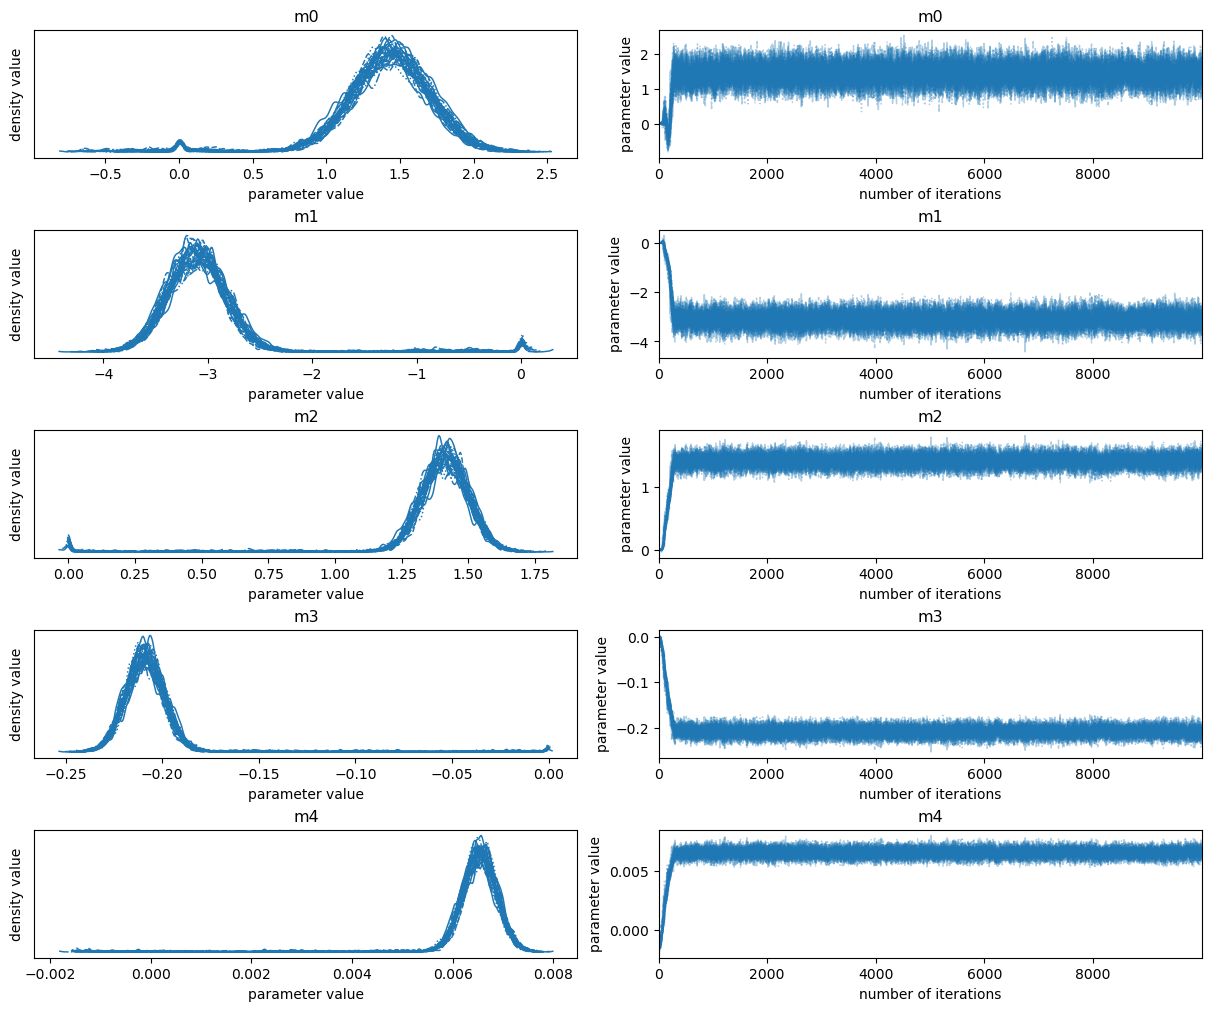

In [33]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    #ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [34]:
#tau = sampler.get_autocorr_time()
#print(f"autocorrelation time: {tau}")

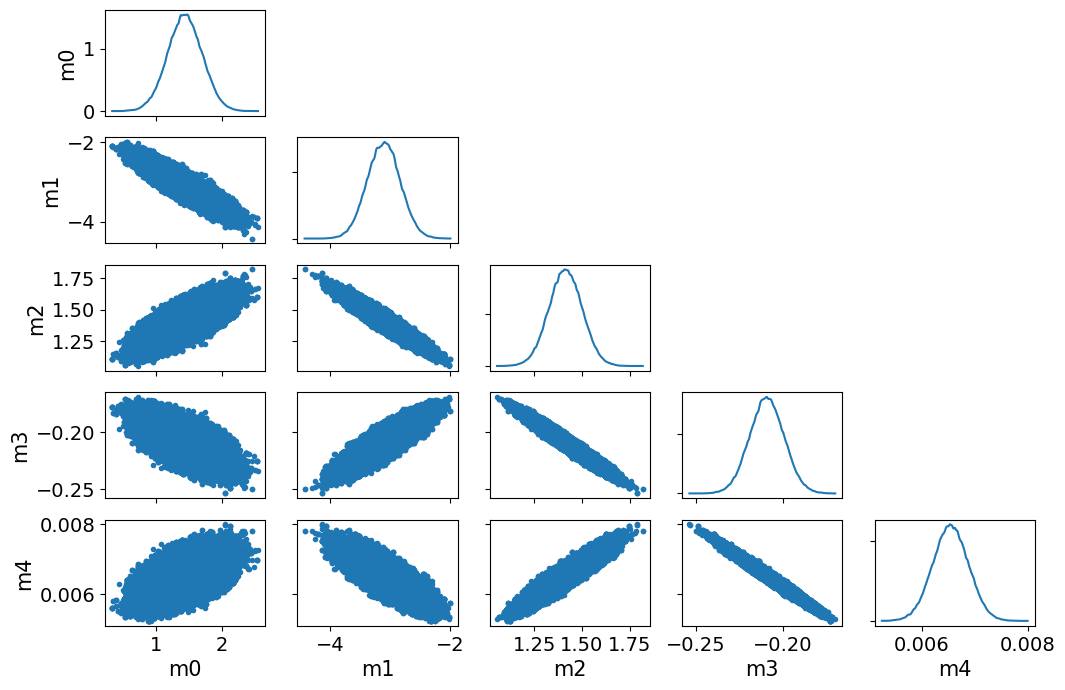

In [35]:
# a Corner plot

fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))

if(True): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );

Now we plot the predicted curves for the posterior ensemble of solutions.

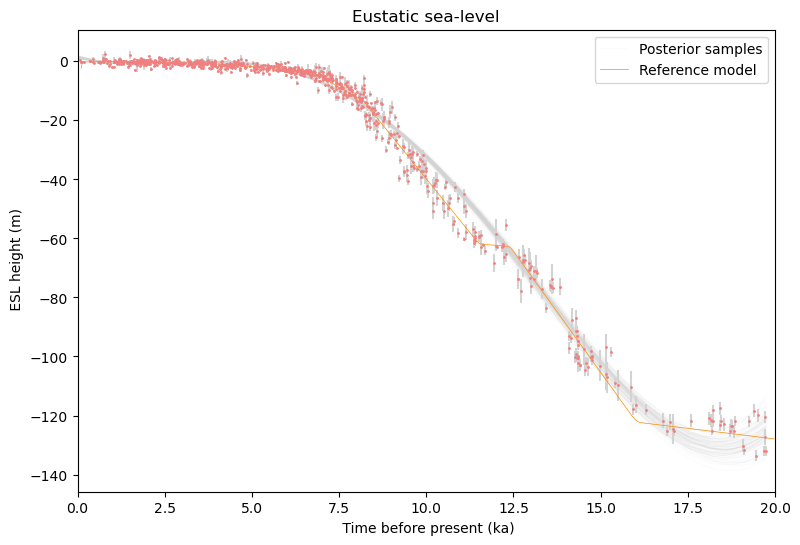

In [36]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data(title="Eustatic sea-level")
plt.xlim(0,maxtime)
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")
#plt.xlim(15,20.)
#plt.ylim(-140,-100)

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [37]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   1.439 [  1.010,   1.864]
 m1  -3.110 [ -3.560,  -2.663]
 m2   1.413 [  1.270,   1.554]
 m3  -0.209 [ -0.225,  -0.193]
 m4   0.007 [  0.006,   0.007]


In [38]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 6.71395495e-02 -6.31440655e-02  1.69522085e-02 -1.64710901e-03
   4.93730689e-05]
 [-6.31440655e-02  7.46106265e-02 -2.25378627e-02  2.35452891e-03
  -7.34981919e-05]
 [ 1.69522085e-02 -2.25378627e-02  7.46679006e-03 -8.32818844e-04
   2.70069602e-05]
 [-1.64710901e-03  2.35452891e-03 -8.32818844e-04  9.78495923e-05
  -3.27713498e-06]
 [ 4.93730689e-05 -7.34981919e-05  2.70069602e-05 -3.27713498e-06
   1.12584263e-07]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.2591
    m1  0.2731
    m2  0.0864
    m3  0.0099
    m4  0.0003


---------

### Challenge - Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-0.5,-10.,-10.,-10.)$, and ${\mathbf u}^T = (0.5,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [39]:
# Copy the template above, Replace <CHANGE ME> with your answer



  0%|                                                                                                                                                                                                                                                                           | 0/10000 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                                                                                                                | 13/10000 [00:00<01:20, 124.16it/s]

  0%|▋                                                                                                                                                                                                                                                                | 27/10000 [00:00<01:16, 130.78it/s]

  0%|█                                                                                                                                                                                                                                                                | 41/10000 [00:00<01:14, 133.69it/s]

  1%|█▍                                                                                                                                                                                                                                                               | 55/10000 [00:00<01:17, 128.18it/s]

  1%|█▊                                                                                                                                                                                                                                                                | 68/10000 [00:00<01:40, 99.20it/s]

  1%|██                                                                                                                                                                                                                                                                | 79/10000 [00:00<01:53, 87.09it/s]

  1%|██▎                                                                                                                                                                                                                                                               | 89/10000 [00:00<02:00, 82.13it/s]

  1%|██▋                                                                                                                                                                                                                                                              | 103/10000 [00:01<01:43, 95.81it/s]

  1%|██▉                                                                                                                                                                                                                                                             | 115/10000 [00:01<01:38, 100.36it/s]

  1%|███▏                                                                                                                                                                                                                                                             | 126/10000 [00:01<01:50, 89.28it/s]

  1%|███▍                                                                                                                                                                                                                                                             | 136/10000 [00:01<01:59, 82.81it/s]

  1%|███▊                                                                                                                                                                                                                                                             | 149/10000 [00:01<01:45, 93.06it/s]

  2%|████▏                                                                                                                                                                                                                                                           | 164/10000 [00:01<01:31, 106.99it/s]

  2%|████▌                                                                                                                                                                                                                                                           | 176/10000 [00:01<01:30, 108.35it/s]

  2%|████▊                                                                                                                                                                                                                                                            | 188/10000 [00:01<01:44, 93.82it/s]

  2%|█████▏                                                                                                                                                                                                                                                           | 200/10000 [00:02<01:39, 98.78it/s]

  2%|█████▍                                                                                                                                                                                                                                                          | 214/10000 [00:02<01:31, 106.61it/s]

  2%|█████▊                                                                                                                                                                                                                                                          | 226/10000 [00:02<01:37, 100.17it/s]

  2%|██████▏                                                                                                                                                                                                                                                         | 241/10000 [00:02<01:26, 112.40it/s]

  3%|██████▌                                                                                                                                                                                                                                                         | 256/10000 [00:02<01:19, 122.33it/s]

  3%|██████▉                                                                                                                                                                                                                                                         | 271/10000 [00:02<01:14, 129.93it/s]

  3%|███████▎                                                                                                                                                                                                                                                        | 286/10000 [00:02<01:12, 134.80it/s]

  3%|███████▋                                                                                                                                                                                                                                                        | 302/10000 [00:02<01:09, 139.41it/s]

  3%|████████                                                                                                                                                                                                                                                        | 317/10000 [00:02<01:08, 141.85it/s]

  3%|████████▍                                                                                                                                                                                                                                                       | 332/10000 [00:02<01:07, 142.78it/s]

  3%|████████▉                                                                                                                                                                                                                                                       | 348/10000 [00:03<01:06, 146.03it/s]

  4%|█████████▎                                                                                                                                                                                                                                                      | 364/10000 [00:03<01:05, 148.17it/s]

  4%|█████████▋                                                                                                                                                                                                                                                      | 379/10000 [00:03<01:04, 148.68it/s]

  4%|██████████                                                                                                                                                                                                                                                      | 394/10000 [00:03<01:04, 148.34it/s]

  4%|██████████▍                                                                                                                                                                                                                                                     | 409/10000 [00:03<01:04, 148.81it/s]

  4%|██████████▊                                                                                                                                                                                                                                                     | 424/10000 [00:03<01:04, 149.06it/s]

  4%|███████████▎                                                                                                                                                                                                                                                    | 440/10000 [00:03<01:03, 149.67it/s]

  5%|███████████▋                                                                                                                                                                                                                                                    | 455/10000 [00:03<01:04, 148.52it/s]

  5%|████████████                                                                                                                                                                                                                                                    | 470/10000 [00:03<01:04, 147.84it/s]

  5%|████████████▍                                                                                                                                                                                                                                                   | 485/10000 [00:04<01:04, 147.88it/s]

  5%|████████████▊                                                                                                                                                                                                                                                   | 501/10000 [00:04<01:03, 149.24it/s]

  5%|█████████████▏                                                                                                                                                                                                                                                  | 517/10000 [00:04<01:02, 151.92it/s]

  5%|█████████████▋                                                                                                                                                                                                                                                  | 533/10000 [00:04<01:02, 151.89it/s]

  5%|██████████████                                                                                                                                                                                                                                                  | 549/10000 [00:04<01:01, 152.84it/s]

  6%|██████████████▍                                                                                                                                                                                                                                                 | 565/10000 [00:04<01:01, 153.02it/s]

  6%|██████████████▊                                                                                                                                                                                                                                                 | 581/10000 [00:04<01:01, 151.95it/s]

  6%|███████████████▎                                                                                                                                                                                                                                                | 597/10000 [00:04<01:02, 151.48it/s]

  6%|███████████████▋                                                                                                                                                                                                                                                | 613/10000 [00:04<01:01, 151.57it/s]

  6%|████████████████                                                                                                                                                                                                                                                | 629/10000 [00:04<01:01, 151.71it/s]

  6%|████████████████▌                                                                                                                                                                                                                                               | 645/10000 [00:05<01:12, 129.31it/s]

  7%|████████████████▉                                                                                                                                                                                                                                               | 661/10000 [00:05<01:09, 134.92it/s]

  7%|█████████████████▎                                                                                                                                                                                                                                              | 677/10000 [00:05<01:06, 139.73it/s]

  7%|█████████████████▋                                                                                                                                                                                                                                              | 692/10000 [00:05<01:05, 142.09it/s]

  7%|██████████████████                                                                                                                                                                                                                                              | 708/10000 [00:05<01:03, 146.96it/s]

  7%|██████████████████▌                                                                                                                                                                                                                                             | 724/10000 [00:05<01:02, 148.83it/s]

  7%|██████████████████▉                                                                                                                                                                                                                                             | 740/10000 [00:05<01:01, 150.60it/s]

  8%|███████████████████▎                                                                                                                                                                                                                                            | 756/10000 [00:05<01:00, 151.84it/s]

  8%|███████████████████▊                                                                                                                                                                                                                                            | 772/10000 [00:05<01:00, 151.49it/s]

  8%|████████████████████▏                                                                                                                                                                                                                                           | 788/10000 [00:06<01:00, 152.67it/s]

  8%|████████████████████▌                                                                                                                                                                                                                                           | 804/10000 [00:06<01:01, 150.42it/s]

  8%|████████████████████▉                                                                                                                                                                                                                                           | 820/10000 [00:06<01:00, 151.64it/s]

  8%|█████████████████████▍                                                                                                                                                                                                                                          | 836/10000 [00:06<01:00, 151.94it/s]

  9%|█████████████████████▊                                                                                                                                                                                                                                          | 852/10000 [00:06<01:00, 152.16it/s]

  9%|██████████████████████▏                                                                                                                                                                                                                                         | 868/10000 [00:06<00:59, 153.58it/s]

  9%|██████████████████████▋                                                                                                                                                                                                                                         | 884/10000 [00:06<00:59, 153.00it/s]

  9%|███████████████████████                                                                                                                                                                                                                                         | 900/10000 [00:06<01:00, 150.94it/s]

  9%|███████████████████████▍                                                                                                                                                                                                                                        | 916/10000 [00:06<01:00, 150.70it/s]

  9%|███████████████████████▊                                                                                                                                                                                                                                        | 932/10000 [00:07<01:00, 149.73it/s]

  9%|████████████████████████▎                                                                                                                                                                                                                                       | 948/10000 [00:07<00:59, 151.41it/s]

 10%|████████████████████████▋                                                                                                                                                                                                                                       | 964/10000 [00:07<00:59, 151.96it/s]

 10%|█████████████████████████                                                                                                                                                                                                                                       | 980/10000 [00:07<00:59, 152.62it/s]

 10%|█████████████████████████▍                                                                                                                                                                                                                                      | 996/10000 [00:07<00:59, 151.76it/s]

 10%|█████████████████████████▊                                                                                                                                                                                                                                     | 1012/10000 [00:07<00:59, 151.56it/s]

 10%|██████████████████████████▏                                                                                                                                                                                                                                    | 1028/10000 [00:07<00:58, 152.79it/s]

 10%|██████████████████████████▌                                                                                                                                                                                                                                    | 1044/10000 [00:07<00:58, 152.95it/s]

 11%|███████████████████████████                                                                                                                                                                                                                                    | 1060/10000 [00:07<00:58, 151.91it/s]

 11%|███████████████████████████▍                                                                                                                                                                                                                                   | 1076/10000 [00:07<00:58, 153.05it/s]

 11%|███████████████████████████▊                                                                                                                                                                                                                                   | 1092/10000 [00:08<00:58, 152.57it/s]

 11%|████████████████████████████▎                                                                                                                                                                                                                                  | 1108/10000 [00:08<00:58, 153.05it/s]

 11%|████████████████████████████▋                                                                                                                                                                                                                                  | 1124/10000 [00:08<00:57, 154.02it/s]

 11%|█████████████████████████████                                                                                                                                                                                                                                  | 1140/10000 [00:08<00:57, 154.12it/s]

 12%|█████████████████████████████▍                                                                                                                                                                                                                                 | 1156/10000 [00:08<00:57, 152.94it/s]

 12%|█████████████████████████████▉                                                                                                                                                                                                                                 | 1172/10000 [00:08<00:58, 152.20it/s]

 12%|██████████████████████████████▎                                                                                                                                                                                                                                | 1188/10000 [00:08<00:57, 153.75it/s]

 12%|██████████████████████████████▋                                                                                                                                                                                                                                | 1204/10000 [00:08<00:57, 153.61it/s]

 12%|███████████████████████████████                                                                                                                                                                                                                                | 1220/10000 [00:08<00:57, 152.35it/s]

 12%|███████████████████████████████▌                                                                                                                                                                                                                               | 1236/10000 [00:08<00:57, 151.64it/s]

 13%|███████████████████████████████▉                                                                                                                                                                                                                               | 1252/10000 [00:09<00:57, 152.36it/s]

 13%|████████████████████████████████▎                                                                                                                                                                                                                              | 1268/10000 [00:09<01:04, 135.24it/s]

 13%|████████████████████████████████▋                                                                                                                                                                                                                              | 1282/10000 [00:09<01:07, 129.79it/s]

 13%|█████████████████████████████████                                                                                                                                                                                                                              | 1296/10000 [00:09<01:15, 114.89it/s]

 13%|█████████████████████████████████▍                                                                                                                                                                                                                             | 1309/10000 [00:09<01:13, 118.01it/s]

 13%|█████████████████████████████████▊                                                                                                                                                                                                                             | 1325/10000 [00:09<01:07, 128.26it/s]

 13%|██████████████████████████████████▏                                                                                                                                                                                                                            | 1341/10000 [00:09<01:04, 135.09it/s]

 14%|██████████████████████████████████▌                                                                                                                                                                                                                            | 1357/10000 [00:09<01:01, 139.90it/s]

 14%|██████████████████████████████████▉                                                                                                                                                                                                                            | 1372/10000 [00:10<01:00, 141.84it/s]

 14%|███████████████████████████████████▍                                                                                                                                                                                                                           | 1388/10000 [00:10<00:59, 145.05it/s]

 14%|███████████████████████████████████▊                                                                                                                                                                                                                           | 1404/10000 [00:10<00:58, 147.60it/s]

 14%|████████████████████████████████████▏                                                                                                                                                                                                                          | 1420/10000 [00:10<00:57, 148.91it/s]

 14%|████████████████████████████████████▌                                                                                                                                                                                                                          | 1436/10000 [00:10<00:56, 150.81it/s]

 15%|█████████████████████████████████████                                                                                                                                                                                                                          | 1452/10000 [00:10<00:56, 151.75it/s]

 15%|█████████████████████████████████████▍                                                                                                                                                                                                                         | 1468/10000 [00:10<00:56, 150.89it/s]

 15%|█████████████████████████████████████▊                                                                                                                                                                                                                         | 1484/10000 [00:10<01:02, 135.26it/s]

 15%|██████████████████████████████████████▏                                                                                                                                                                                                                        | 1498/10000 [00:10<01:15, 112.69it/s]

 15%|██████████████████████████████████████▌                                                                                                                                                                                                                        | 1511/10000 [00:11<01:14, 114.20it/s]

 15%|██████████████████████████████████████▉                                                                                                                                                                                                                        | 1527/10000 [00:11<01:08, 124.39it/s]

 15%|███████████████████████████████████████▎                                                                                                                                                                                                                       | 1543/10000 [00:11<01:03, 132.79it/s]

 16%|███████████████████████████████████████▊                                                                                                                                                                                                                       | 1559/10000 [00:11<01:00, 139.45it/s]

 16%|████████████████████████████████████████▏                                                                                                                                                                                                                      | 1575/10000 [00:11<00:58, 143.58it/s]

 16%|████████████████████████████████████████▌                                                                                                                                                                                                                      | 1591/10000 [00:11<00:57, 147.18it/s]

 16%|████████████████████████████████████████▉                                                                                                                                                                                                                      | 1607/10000 [00:11<00:56, 149.43it/s]

 16%|█████████████████████████████████████████▍                                                                                                                                                                                                                     | 1623/10000 [00:11<00:55, 151.31it/s]

 16%|█████████████████████████████████████████▊                                                                                                                                                                                                                     | 1639/10000 [00:11<00:55, 151.42it/s]

 17%|██████████████████████████████████████████▏                                                                                                                                                                                                                    | 1655/10000 [00:12<00:55, 151.15it/s]

 17%|██████████████████████████████████████████▌                                                                                                                                                                                                                    | 1671/10000 [00:12<00:54, 152.56it/s]

 17%|███████████████████████████████████████████                                                                                                                                                                                                                    | 1687/10000 [00:12<00:54, 153.36it/s]

 17%|███████████████████████████████████████████▍                                                                                                                                                                                                                   | 1703/10000 [00:12<01:13, 113.35it/s]

 17%|███████████████████████████████████████████▉                                                                                                                                                                                                                    | 1716/10000 [00:12<01:56, 71.07it/s]

 17%|████████████████████████████████████████████▏                                                                                                                                                                                                                   | 1727/10000 [00:13<02:13, 62.15it/s]

 17%|████████████████████████████████████████████▍                                                                                                                                                                                                                   | 1736/10000 [00:13<02:32, 54.16it/s]

 18%|████████████████████████████████████████████▊                                                                                                                                                                                                                   | 1751/10000 [00:13<01:59, 69.19it/s]

 18%|█████████████████████████████████████████████▏                                                                                                                                                                                                                  | 1764/10000 [00:13<01:43, 79.51it/s]

 18%|█████████████████████████████████████████████▍                                                                                                                                                                                                                  | 1775/10000 [00:13<01:52, 73.24it/s]

 18%|█████████████████████████████████████████████▋                                                                                                                                                                                                                  | 1787/10000 [00:13<01:39, 82.62it/s]

 18%|██████████████████████████████████████████████▏                                                                                                                                                                                                                 | 1803/10000 [00:13<01:22, 98.84it/s]

 18%|██████████████████████████████████████████████▎                                                                                                                                                                                                                | 1818/10000 [00:14<01:14, 110.44it/s]

 18%|██████████████████████████████████████████████▋                                                                                                                                                                                                                | 1831/10000 [00:14<01:20, 101.42it/s]

 18%|███████████████████████████████████████████████▏                                                                                                                                                                                                                | 1843/10000 [00:14<01:39, 82.39it/s]

 19%|███████████████████████████████████████████████▌                                                                                                                                                                                                                | 1859/10000 [00:14<01:22, 98.23it/s]

 19%|███████████████████████████████████████████████▉                                                                                                                                                                                                                | 1871/10000 [00:14<01:22, 98.61it/s]

 19%|████████████████████████████████████████████████                                                                                                                                                                                                               | 1887/10000 [00:14<01:12, 112.19it/s]

 19%|████████████████████████████████████████████████▌                                                                                                                                                                                                              | 1903/10000 [00:14<01:05, 123.72it/s]

 19%|████████████████████████████████████████████████▉                                                                                                                                                                                                              | 1919/10000 [00:14<01:01, 132.30it/s]

 19%|█████████████████████████████████████████████████▎                                                                                                                                                                                                             | 1935/10000 [00:15<00:57, 139.79it/s]

 20%|█████████████████████████████████████████████████▊                                                                                                                                                                                                             | 1951/10000 [00:15<00:55, 144.35it/s]

 20%|██████████████████████████████████████████████████▏                                                                                                                                                                                                            | 1967/10000 [00:15<00:54, 147.43it/s]

 20%|██████████████████████████████████████████████████▌                                                                                                                                                                                                            | 1983/10000 [00:15<00:54, 148.30it/s]

 20%|██████████████████████████████████████████████████▉                                                                                                                                                                                                            | 1999/10000 [00:15<00:53, 149.25it/s]

 20%|███████████████████████████████████████████████████▍                                                                                                                                                                                                           | 2015/10000 [00:15<00:52, 151.48it/s]

 20%|███████████████████████████████████████████████████▊                                                                                                                                                                                                           | 2031/10000 [00:15<00:51, 153.43it/s]

 20%|████████████████████████████████████████████████████▏                                                                                                                                                                                                          | 2047/10000 [00:15<00:52, 150.96it/s]

 21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                          | 2063/10000 [00:15<01:01, 130.10it/s]

 21%|████████████████████████████████████████████████████▉                                                                                                                                                                                                          | 2077/10000 [00:16<01:00, 130.81it/s]

 21%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                         | 2091/10000 [00:16<01:02, 127.12it/s]

 21%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 2104/10000 [00:16<01:07, 117.44it/s]

 21%|██████████████████████████████████████████████████████                                                                                                                                                                                                         | 2120/10000 [00:16<01:02, 126.69it/s]

 21%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 2133/10000 [00:16<01:10, 111.97it/s]

 21%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 2145/10000 [00:16<01:10, 112.18it/s]

 22%|███████████████████████████████████████████████████████                                                                                                                                                                                                        | 2160/10000 [00:16<01:04, 121.85it/s]

 22%|███████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 2173/10000 [00:16<01:07, 116.70it/s]

 22%|███████████████████████████████████████████████████████▊                                                                                                                                                                                                       | 2188/10000 [00:16<01:02, 125.54it/s]

 22%|████████████████████████████████████████████████████████▏                                                                                                                                                                                                      | 2204/10000 [00:17<00:58, 133.76it/s]

 22%|████████████████████████████████████████████████████████▋                                                                                                                                                                                                      | 2221/10000 [00:17<00:54, 142.54it/s]

 22%|█████████████████████████████████████████████████████████                                                                                                                                                                                                      | 2237/10000 [00:17<00:52, 147.00it/s]

 23%|█████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 2253/10000 [00:17<00:51, 149.56it/s]

 23%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                     | 2269/10000 [00:17<00:51, 151.45it/s]

 23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                    | 2285/10000 [00:17<00:52, 147.03it/s]

 23%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 2300/10000 [00:17<00:52, 146.75it/s]

 23%|███████████████████████████████████████████████████████████                                                                                                                                                                                                    | 2316/10000 [00:17<00:51, 148.81it/s]

 23%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                                   | 2332/10000 [00:17<00:50, 151.73it/s]

 23%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                                   | 2348/10000 [00:18<00:49, 153.39it/s]

 24%|████████████████████████████████████████████████████████████▎                                                                                                                                                                                                  | 2364/10000 [00:18<00:55, 136.76it/s]

 24%|████████████████████████████████████████████████████████████▋                                                                                                                                                                                                  | 2379/10000 [00:18<01:01, 124.48it/s]

 24%|█████████████████████████████████████████████████████████████                                                                                                                                                                                                  | 2395/10000 [00:18<00:57, 132.15it/s]

 24%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                 | 2410/10000 [00:18<00:55, 136.72it/s]

 24%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 2426/10000 [00:18<00:53, 140.68it/s]

 24%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 2441/10000 [00:18<00:52, 142.96it/s]

 25%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 2456/10000 [00:18<00:52, 142.86it/s]

 25%|███████████████████████████████████████████████████████████████                                                                                                                                                                                                | 2472/10000 [00:18<00:51, 146.70it/s]

 25%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                                               | 2488/10000 [00:19<00:50, 148.23it/s]

 25%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                                               | 2504/10000 [00:19<00:49, 150.09it/s]

 25%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 2520/10000 [00:19<00:49, 151.02it/s]

 25%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                                              | 2536/10000 [00:19<00:49, 151.20it/s]

 26%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 2552/10000 [00:19<00:48, 152.10it/s]

 26%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 2568/10000 [00:19<00:55, 134.54it/s]

 26%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 2583/10000 [00:19<00:53, 137.47it/s]

 26%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 2598/10000 [00:19<00:52, 140.61it/s]

 26%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 2613/10000 [00:19<00:51, 142.18it/s]

 26%|███████████████████████████████████████████████████████████████████                                                                                                                                                                                            | 2629/10000 [00:20<00:51, 144.38it/s]

 26%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                                                           | 2645/10000 [00:20<00:49, 147.90it/s]

 27%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                                                           | 2660/10000 [00:20<00:49, 148.35it/s]

 27%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                          | 2675/10000 [00:20<00:49, 148.54it/s]

 27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 2690/10000 [00:20<00:49, 147.96it/s]

 27%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 2706/10000 [00:20<00:48, 149.46it/s]

 27%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 2722/10000 [00:20<00:48, 150.36it/s]

 27%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 2738/10000 [00:20<00:48, 150.43it/s]

 28%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                        | 2754/10000 [00:20<00:48, 150.69it/s]

 28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                        | 2770/10000 [00:20<00:47, 150.73it/s]

 28%|███████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 2786/10000 [00:21<00:47, 152.81it/s]

 28%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                       | 2802/10000 [00:21<00:46, 153.28it/s]

 28%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                       | 2818/10000 [00:21<00:46, 153.90it/s]

 28%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 2834/10000 [00:21<00:46, 153.90it/s]

 28%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                      | 2850/10000 [00:21<00:46, 153.76it/s]

 29%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 2866/10000 [00:21<00:46, 153.09it/s]

 29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 2882/10000 [00:21<00:46, 152.52it/s]

 29%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 2898/10000 [00:21<00:47, 150.42it/s]

 29%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                    | 2914/10000 [00:21<00:46, 152.27it/s]

 29%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 2930/10000 [00:21<00:46, 153.04it/s]

 29%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                                    | 2946/10000 [00:22<00:45, 153.50it/s]

 30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 2962/10000 [00:22<00:45, 154.79it/s]

 30%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 2978/10000 [00:22<00:45, 155.28it/s]

 30%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 2994/10000 [00:22<00:45, 155.23it/s]

 30%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                  | 3010/10000 [00:22<00:45, 154.08it/s]

 30%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 3026/10000 [00:22<00:45, 154.80it/s]

 30%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 3042/10000 [00:22<00:44, 155.10it/s]

 31%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                 | 3058/10000 [00:22<00:46, 149.26it/s]

 31%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                | 3073/10000 [00:22<00:46, 149.38it/s]

 31%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                | 3089/10000 [00:23<00:46, 150.17it/s]

 31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 3105/10000 [00:23<00:45, 151.65it/s]

 31%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 3121/10000 [00:23<00:45, 151.68it/s]

 31%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 3137/10000 [00:23<00:45, 152.48it/s]

 32%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                              | 3153/10000 [00:23<00:44, 153.43it/s]

 32%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 3170/10000 [00:23<00:43, 155.84it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 3187/10000 [00:23<00:43, 157.60it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 3204/10000 [00:23<00:42, 159.47it/s]

 32%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 3220/10000 [00:23<00:42, 158.17it/s]

 32%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 3236/10000 [00:23<00:43, 156.21it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                            | 3252/10000 [00:24<00:43, 154.30it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 3268/10000 [00:24<00:43, 154.15it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 3284/10000 [00:24<00:52, 127.73it/s]

 33%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 3300/10000 [00:24<00:50, 133.77it/s]

 33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 3314/10000 [00:24<00:55, 119.62it/s]

 33%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 3330/10000 [00:24<00:51, 128.86it/s]

 33%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 3344/10000 [00:24<00:50, 131.47it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 3360/10000 [00:24<00:48, 137.53it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                         | 3375/10000 [00:25<00:50, 131.35it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 3389/10000 [00:25<00:49, 132.40it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 3404/10000 [00:25<00:48, 136.94it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                       | 3419/10000 [00:25<00:49, 134.26it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 3433/10000 [00:25<00:50, 129.15it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 3447/10000 [00:25<00:50, 128.86it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 3463/10000 [00:25<00:48, 135.46it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 3477/10000 [00:25<00:49, 130.74it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 3492/10000 [00:25<00:48, 134.27it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 3506/10000 [00:26<00:47, 135.54it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 3520/10000 [00:26<00:50, 129.34it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 3534/10000 [00:26<00:50, 127.25it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                    | 3547/10000 [00:26<00:54, 118.60it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 3562/10000 [00:26<00:51, 126.21it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 3577/10000 [00:26<00:48, 132.72it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 3592/10000 [00:26<00:47, 135.86it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 3606/10000 [00:26<00:49, 128.50it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                  | 3620/10000 [00:26<00:49, 129.12it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 3636/10000 [00:27<00:46, 136.08it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                  | 3650/10000 [00:27<00:50, 126.47it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 3664/10000 [00:27<00:48, 129.95it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 3680/10000 [00:27<00:46, 136.78it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 3696/10000 [00:27<00:44, 141.13it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 3711/10000 [00:27<00:44, 142.55it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                | 3726/10000 [00:27<00:44, 139.64it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                               | 3741/10000 [00:27<00:44, 141.36it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 3757/10000 [00:27<00:43, 144.38it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 3773/10000 [00:27<00:42, 147.01it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 3788/10000 [00:28<00:42, 147.54it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 3804/10000 [00:28<00:41, 148.78it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 3819/10000 [00:28<00:41, 148.38it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 3835/10000 [00:28<00:41, 149.65it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 3851/10000 [00:28<00:40, 151.26it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 3867/10000 [00:28<00:40, 152.50it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                            | 3883/10000 [00:28<00:40, 152.21it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 3899/10000 [00:28<00:39, 152.87it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 3915/10000 [00:28<00:39, 153.07it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 3931/10000 [00:29<00:39, 153.80it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 3947/10000 [00:29<00:39, 153.09it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 3963/10000 [00:29<00:39, 152.94it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 3979/10000 [00:29<00:39, 153.18it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 3995/10000 [00:29<00:38, 154.17it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 4011/10000 [00:29<00:38, 153.89it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 4027/10000 [00:29<00:38, 154.53it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                        | 4043/10000 [00:29<00:38, 154.09it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 4059/10000 [00:29<00:40, 145.62it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 4075/10000 [00:29<00:39, 148.90it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 4090/10000 [00:30<00:50, 116.33it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 4106/10000 [00:30<00:46, 125.44it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 4121/10000 [00:30<00:44, 131.29it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 4137/10000 [00:30<00:42, 138.65it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 4153/10000 [00:30<00:40, 143.76it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 4169/10000 [00:30<00:39, 146.14it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 4184/10000 [00:30<00:39, 147.07it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 4199/10000 [00:30<00:44, 130.64it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 4215/10000 [00:31<00:42, 136.96it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 4231/10000 [00:31<00:40, 140.98it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 4247/10000 [00:31<00:39, 144.81it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 4262/10000 [00:31<00:43, 132.92it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 4278/10000 [00:31<00:41, 138.95it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 4294/10000 [00:31<00:39, 143.82it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 4310/10000 [00:31<00:38, 147.99it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 4326/10000 [00:31<00:37, 150.37it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 4342/10000 [00:31<00:37, 151.89it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 4358/10000 [00:32<00:37, 149.09it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 4374/10000 [00:32<00:39, 141.58it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 4389/10000 [00:32<00:41, 135.73it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 4403/10000 [00:32<00:41, 135.27it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 4419/10000 [00:32<00:39, 139.62it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 4434/10000 [00:32<00:39, 141.46it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 4449/10000 [00:32<00:39, 140.87it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 4464/10000 [00:32<00:38, 143.06it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 4480/10000 [00:32<00:37, 145.64it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 4496/10000 [00:33<00:37, 147.63it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 4512/10000 [00:33<00:36, 149.80it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 4528/10000 [00:33<00:36, 151.57it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 4544/10000 [00:33<00:36, 150.97it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 4560/10000 [00:33<00:35, 152.01it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 4576/10000 [00:33<00:35, 151.89it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 4592/10000 [00:33<00:35, 151.31it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 4608/10000 [00:33<00:36, 149.31it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 4624/10000 [00:33<00:35, 150.62it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 4640/10000 [00:33<00:35, 151.71it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 4656/10000 [00:34<00:34, 152.88it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 4672/10000 [00:34<00:34, 153.20it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 4688/10000 [00:34<00:34, 153.77it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 4704/10000 [00:34<00:35, 150.51it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 4720/10000 [00:34<00:35, 149.71it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 4736/10000 [00:34<00:34, 150.87it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 4752/10000 [00:34<00:34, 151.23it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 4768/10000 [00:34<00:34, 152.53it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 4784/10000 [00:34<00:33, 154.20it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 4800/10000 [00:34<00:33, 154.71it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 4816/10000 [00:35<00:33, 154.78it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 4832/10000 [00:35<00:33, 156.03it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 4848/10000 [00:35<00:32, 156.71it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 4864/10000 [00:35<00:32, 157.35it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 4880/10000 [00:35<00:32, 156.45it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 4896/10000 [00:35<00:32, 154.79it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 4912/10000 [00:35<00:33, 153.85it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 4928/10000 [00:35<00:33, 152.18it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 4944/10000 [00:35<00:33, 151.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 4960/10000 [00:36<00:32, 152.87it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 4976/10000 [00:36<00:37, 133.91it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 4990/10000 [00:36<00:37, 134.14it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 5006/10000 [00:36<00:35, 140.44it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 5022/10000 [00:36<00:34, 145.41it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 5038/10000 [00:36<00:33, 148.41it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 5054/10000 [00:36<00:33, 149.11it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 5070/10000 [00:36<00:33, 148.36it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 5086/10000 [00:36<00:32, 150.13it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 5102/10000 [00:37<00:32, 150.04it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 5118/10000 [00:37<00:32, 151.46it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 5134/10000 [00:37<00:32, 151.72it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5150/10000 [00:37<00:32, 150.83it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 5166/10000 [00:37<00:32, 150.98it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 5182/10000 [00:37<00:31, 152.04it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 5198/10000 [00:37<00:31, 153.33it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 5214/10000 [00:37<00:31, 152.98it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 5230/10000 [00:37<00:31, 153.01it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 5246/10000 [00:37<00:30, 153.60it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 5262/10000 [00:38<00:31, 152.11it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 5278/10000 [00:38<00:31, 151.79it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 5294/10000 [00:38<00:30, 151.96it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 5310/10000 [00:38<00:30, 151.99it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 5326/10000 [00:38<00:30, 151.47it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 5342/10000 [00:38<00:30, 152.46it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 5358/10000 [00:38<00:30, 152.61it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 5374/10000 [00:38<00:30, 153.75it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 5390/10000 [00:38<00:29, 155.06it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 5406/10000 [00:39<00:29, 154.60it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 5422/10000 [00:39<00:29, 154.92it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 5438/10000 [00:39<00:29, 153.90it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 5454/10000 [00:39<00:29, 154.81it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 5470/10000 [00:39<00:29, 155.72it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 5486/10000 [00:39<00:28, 155.76it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 5502/10000 [00:39<00:29, 153.39it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 5518/10000 [00:39<00:29, 151.60it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 5534/10000 [00:39<00:29, 151.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 5550/10000 [00:39<00:29, 152.18it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 5566/10000 [00:40<00:28, 152.93it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 5582/10000 [00:40<00:32, 134.03it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 5598/10000 [00:40<00:31, 138.70it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 5613/10000 [00:40<00:31, 141.27it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 5628/10000 [00:40<00:30, 143.38it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 5644/10000 [00:40<00:29, 146.27it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 5660/10000 [00:40<00:29, 147.72it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 5676/10000 [00:40<00:29, 148.86it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 5691/10000 [00:40<00:28, 149.04it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 5707/10000 [00:41<00:28, 150.05it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 5723/10000 [00:41<00:28, 151.10it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 5739/10000 [00:41<00:28, 147.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 5755/10000 [00:41<00:28, 148.73it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 5771/10000 [00:41<00:28, 150.19it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 5787/10000 [00:41<00:28, 149.68it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 5803/10000 [00:41<00:27, 151.29it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 5819/10000 [00:41<00:27, 151.77it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 5835/10000 [00:41<00:27, 151.36it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 5851/10000 [00:41<00:27, 152.19it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 5867/10000 [00:42<00:27, 152.05it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 5883/10000 [00:42<00:26, 152.60it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 5899/10000 [00:42<00:28, 143.05it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 5914/10000 [00:42<00:32, 126.53it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 5930/10000 [00:42<00:30, 133.12it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 5944/10000 [00:42<00:35, 114.43it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 5958/10000 [00:42<00:33, 119.96it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 5972/10000 [00:42<00:32, 124.56it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 5988/10000 [00:43<00:30, 133.13it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 6004/10000 [00:43<00:28, 139.71it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 6020/10000 [00:43<00:27, 143.11it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 6035/10000 [00:43<00:27, 144.12it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 6051/10000 [00:43<00:26, 146.66it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 6067/10000 [00:43<00:26, 149.96it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 6083/10000 [00:43<00:26, 150.41it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 6099/10000 [00:43<00:25, 151.58it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 6115/10000 [00:43<00:25, 151.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 6131/10000 [00:43<00:25, 151.59it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 6147/10000 [00:44<00:25, 152.56it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 6163/10000 [00:44<00:25, 152.51it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 6179/10000 [00:44<00:25, 152.59it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 6195/10000 [00:44<00:24, 153.31it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 6211/10000 [00:44<00:24, 153.57it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 6227/10000 [00:44<00:24, 153.02it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 6243/10000 [00:44<00:24, 152.89it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 6259/10000 [00:44<00:24, 153.52it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 6275/10000 [00:44<00:24, 152.11it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 6291/10000 [00:45<00:24, 152.61it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 6307/10000 [00:45<00:24, 153.10it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 6323/10000 [00:45<00:23, 153.26it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 6339/10000 [00:45<00:23, 153.27it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 6355/10000 [00:45<00:23, 153.08it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 6371/10000 [00:45<00:23, 153.99it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 6387/10000 [00:45<00:23, 154.02it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 6403/10000 [00:45<00:23, 151.55it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 6419/10000 [00:45<00:23, 152.31it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 6435/10000 [00:45<00:23, 151.47it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 6451/10000 [00:46<00:24, 144.78it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 6466/10000 [00:46<00:24, 145.80it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 6481/10000 [00:46<00:24, 146.40it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 6497/10000 [00:46<00:23, 147.77it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 6513/10000 [00:46<00:23, 148.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 6529/10000 [00:46<00:23, 149.65it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 6545/10000 [00:46<00:22, 150.73it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 6561/10000 [00:46<00:22, 150.38it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 6577/10000 [00:46<00:22, 150.23it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 6593/10000 [00:47<00:22, 150.13it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 6609/10000 [00:47<00:22, 150.96it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 6625/10000 [00:47<00:22, 151.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 6641/10000 [00:47<00:22, 152.61it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 6657/10000 [00:47<00:21, 153.29it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 6673/10000 [00:47<00:21, 154.29it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 6689/10000 [00:47<00:21, 152.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 6705/10000 [00:47<00:21, 152.52it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 6721/10000 [00:47<00:21, 153.31it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 6737/10000 [00:47<00:21, 154.39it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 6753/10000 [00:48<00:20, 155.81it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6769/10000 [00:48<00:20, 155.17it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 6785/10000 [00:48<00:20, 155.32it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 6801/10000 [00:48<00:20, 155.09it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 6817/10000 [00:48<00:20, 154.07it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 6833/10000 [00:48<00:20, 152.97it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 6849/10000 [00:48<00:20, 151.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 6865/10000 [00:48<00:20, 149.98it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 6881/10000 [00:48<00:20, 149.03it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 6897/10000 [00:49<00:20, 150.59it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 6913/10000 [00:49<00:20, 153.00it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 6929/10000 [00:49<00:20, 153.07it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 6945/10000 [00:49<00:19, 154.39it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 6961/10000 [00:49<00:19, 153.60it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 6977/10000 [00:49<00:19, 154.49it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 6993/10000 [00:49<00:19, 155.71it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 7009/10000 [00:49<00:19, 154.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 7025/10000 [00:49<00:19, 155.94it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 7041/10000 [00:49<00:18, 156.98it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 7057/10000 [00:50<00:18, 157.00it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 7073/10000 [00:50<00:18, 156.43it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 7089/10000 [00:50<00:20, 140.40it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 7104/10000 [00:50<00:24, 118.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 7120/10000 [00:50<00:22, 128.91it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 7134/10000 [00:50<00:23, 122.35it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 7149/10000 [00:50<00:22, 128.72it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 7163/10000 [00:50<00:22, 127.00it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 7179/10000 [00:51<00:20, 135.19it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 7195/10000 [00:51<00:19, 141.52it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 7212/10000 [00:51<00:18, 146.91it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 7228/10000 [00:51<00:18, 149.24it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 7245/10000 [00:51<00:17, 153.27it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 7261/10000 [00:51<00:17, 154.74it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 7277/10000 [00:51<00:17, 154.93it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 7293/10000 [00:51<00:17, 151.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 7309/10000 [00:51<00:17, 152.75it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 7325/10000 [00:51<00:17, 153.53it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 7341/10000 [00:52<00:17, 154.62it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 7357/10000 [00:52<00:17, 154.58it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 7373/10000 [00:52<00:18, 145.27it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 7388/10000 [00:52<00:18, 140.55it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 7403/10000 [00:52<00:18, 141.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 7419/10000 [00:52<00:17, 144.79it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 7435/10000 [00:52<00:17, 147.65it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 7451/10000 [00:52<00:17, 149.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 7467/10000 [00:52<00:16, 151.13it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 7484/10000 [00:53<00:16, 154.28it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 7500/10000 [00:53<00:16, 153.64it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 7516/10000 [00:53<00:16, 155.03it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 7532/10000 [00:53<00:15, 155.09it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 7548/10000 [00:53<00:15, 155.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 7564/10000 [00:53<00:15, 155.04it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 7580/10000 [00:53<00:15, 153.34it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 7596/10000 [00:53<00:15, 153.04it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 7612/10000 [00:53<00:15, 151.71it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 7628/10000 [00:53<00:15, 150.00it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 7644/10000 [00:54<00:15, 150.32it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 7660/10000 [00:54<00:18, 125.19it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 7674/10000 [00:54<00:18, 122.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 7687/10000 [00:54<00:21, 109.29it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 7703/10000 [00:54<00:19, 120.39it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7716/10000 [00:54<00:19, 119.64it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 7729/10000 [00:54<00:20, 110.59it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 7745/10000 [00:54<00:18, 122.28it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 7758/10000 [00:55<00:19, 117.97it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 7771/10000 [00:55<00:21, 103.67it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 7785/10000 [00:55<00:19, 111.44it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 7797/10000 [00:55<00:20, 108.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 7813/10000 [00:55<00:18, 120.67it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 7829/10000 [00:55<00:16, 130.00it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 7845/10000 [00:55<00:15, 137.49it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 7861/10000 [00:55<00:15, 142.21it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 7877/10000 [00:56<00:14, 146.72it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 7893/10000 [00:56<00:14, 149.05it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 7909/10000 [00:56<00:13, 150.45it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 7925/10000 [00:56<00:13, 150.94it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 7941/10000 [00:56<00:13, 151.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 7957/10000 [00:56<00:13, 153.98it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 7973/10000 [00:56<00:13, 153.75it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 7989/10000 [00:56<00:13, 152.50it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 8005/10000 [00:56<00:13, 151.11it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 8021/10000 [00:56<00:13, 150.59it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 8037/10000 [00:57<00:14, 139.06it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 8053/10000 [00:57<00:13, 142.38it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 8069/10000 [00:57<00:13, 145.40it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 8085/10000 [00:57<00:13, 147.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 8101/10000 [00:57<00:12, 148.35it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 8117/10000 [00:57<00:12, 149.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 8133/10000 [00:57<00:12, 151.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 8149/10000 [00:57<00:12, 149.44it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 8165/10000 [00:57<00:12, 150.24it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 8181/10000 [00:58<00:11, 152.27it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 8197/10000 [00:58<00:11, 152.01it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 8213/10000 [00:58<00:11, 152.41it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 8229/10000 [00:58<00:11, 152.76it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 8245/10000 [00:58<00:11, 153.39it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 8261/10000 [00:58<00:11, 154.08it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 8277/10000 [00:58<00:11, 153.15it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 8293/10000 [00:58<00:11, 151.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 8309/10000 [00:58<00:11, 151.92it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 8325/10000 [00:58<00:11, 151.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 8341/10000 [00:59<00:10, 151.61it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 8357/10000 [00:59<00:10, 151.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 8373/10000 [00:59<00:10, 151.16it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 8389/10000 [00:59<00:10, 151.88it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 8405/10000 [00:59<00:10, 152.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 8421/10000 [00:59<00:10, 154.04it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 8437/10000 [00:59<00:10, 155.12it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 8453/10000 [00:59<00:10, 153.94it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 8469/10000 [00:59<00:10, 152.08it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 8485/10000 [01:00<00:10, 151.01it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 8501/10000 [01:00<00:09, 151.58it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 8517/10000 [01:00<00:09, 151.12it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 8533/10000 [01:00<00:13, 111.59it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 8548/10000 [01:00<00:12, 120.10it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 8564/10000 [01:00<00:11, 129.13it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 8579/10000 [01:00<00:10, 133.65it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 8594/10000 [01:00<00:10, 136.38it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8610/10000 [01:00<00:09, 142.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 8626/10000 [01:01<00:09, 144.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 8642/10000 [01:01<00:09, 148.41it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 8658/10000 [01:01<00:08, 150.96it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 8674/10000 [01:01<00:08, 150.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 8690/10000 [01:01<00:08, 150.62it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 8706/10000 [01:01<00:09, 130.68it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 8721/10000 [01:01<00:09, 134.61it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 8736/10000 [01:01<00:09, 137.96it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8751/10000 [01:01<00:08, 141.15it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8767/10000 [01:02<00:08, 144.44it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 8782/10000 [01:02<00:08, 144.12it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 8798/10000 [01:02<00:08, 147.39it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 8814/10000 [01:02<00:07, 149.68it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 8830/10000 [01:02<00:07, 150.67it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8846/10000 [01:02<00:07, 150.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 8862/10000 [01:02<00:07, 150.24it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8878/10000 [01:02<00:07, 150.34it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8894/10000 [01:03<00:09, 117.95it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8909/10000 [01:03<00:08, 121.87it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8923/10000 [01:03<00:09, 119.66it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8939/10000 [01:03<00:08, 129.61it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8955/10000 [01:03<00:07, 136.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8972/10000 [01:03<00:07, 144.25it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8988/10000 [01:03<00:06, 148.30it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 9004/10000 [01:03<00:06, 148.70it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 9020/10000 [01:03<00:06, 151.44it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 9036/10000 [01:03<00:06, 153.41it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 9052/10000 [01:04<00:06, 152.61it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 9068/10000 [01:04<00:07, 129.89it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 9084/10000 [01:04<00:06, 136.27it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 9099/10000 [01:04<00:06, 139.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 9115/10000 [01:04<00:06, 143.49it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 9130/10000 [01:04<00:06, 144.96it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 9146/10000 [01:04<00:05, 147.23it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 9162/10000 [01:04<00:05, 148.24it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 9178/10000 [01:04<00:05, 149.48it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 9194/10000 [01:05<00:05, 149.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 9210/10000 [01:05<00:05, 150.36it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 9226/10000 [01:05<00:05, 150.01it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 9242/10000 [01:05<00:05, 150.12it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 9258/10000 [01:05<00:04, 148.89it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 9273/10000 [01:05<00:04, 148.70it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 9289/10000 [01:05<00:04, 150.27it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 9305/10000 [01:05<00:04, 149.68it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 9320/10000 [01:05<00:04, 148.40it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 9336/10000 [01:06<00:04, 149.24it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9351/10000 [01:06<00:04, 144.08it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 9367/10000 [01:06<00:04, 148.42it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 9383/10000 [01:06<00:04, 150.40it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 9400/10000 [01:06<00:03, 153.60it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9416/10000 [01:06<00:03, 153.47it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9432/10000 [01:06<00:03, 154.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9448/10000 [01:06<00:03, 152.96it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9464/10000 [01:06<00:03, 154.14it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9481/10000 [01:06<00:03, 156.48it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 9497/10000 [01:07<00:03, 140.60it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9513/10000 [01:07<00:03, 144.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9529/10000 [01:07<00:03, 148.33it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9545/10000 [01:07<00:03, 149.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9561/10000 [01:07<00:02, 150.76it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9577/10000 [01:07<00:02, 151.57it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9593/10000 [01:07<00:02, 152.40it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9609/10000 [01:07<00:02, 152.98it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9625/10000 [01:07<00:02, 153.84it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9641/10000 [01:08<00:02, 155.21it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9657/10000 [01:08<00:02, 154.96it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9673/10000 [01:08<00:02, 155.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9689/10000 [01:08<00:02, 153.93it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9706/10000 [01:08<00:01, 156.08it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9722/10000 [01:08<00:01, 154.83it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9738/10000 [01:08<00:01, 152.73it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9754/10000 [01:08<00:01, 153.97it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9770/10000 [01:08<00:01, 153.07it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9786/10000 [01:08<00:01, 154.01it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9802/10000 [01:09<00:01, 155.38it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9818/10000 [01:09<00:01, 131.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9834/10000 [01:09<00:01, 138.83it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9850/10000 [01:09<00:01, 143.09it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9866/10000 [01:09<00:00, 146.04it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9882/10000 [01:09<00:00, 149.57it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9898/10000 [01:09<00:00, 150.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9914/10000 [01:09<00:00, 152.20it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9930/10000 [01:09<00:00, 153.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9946/10000 [01:10<00:00, 155.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9962/10000 [01:10<00:00, 154.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9978/10000 [01:10<00:00, 152.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9994/10000 [01:10<00:00, 153.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:10<00:00, 142.00it/s]

Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


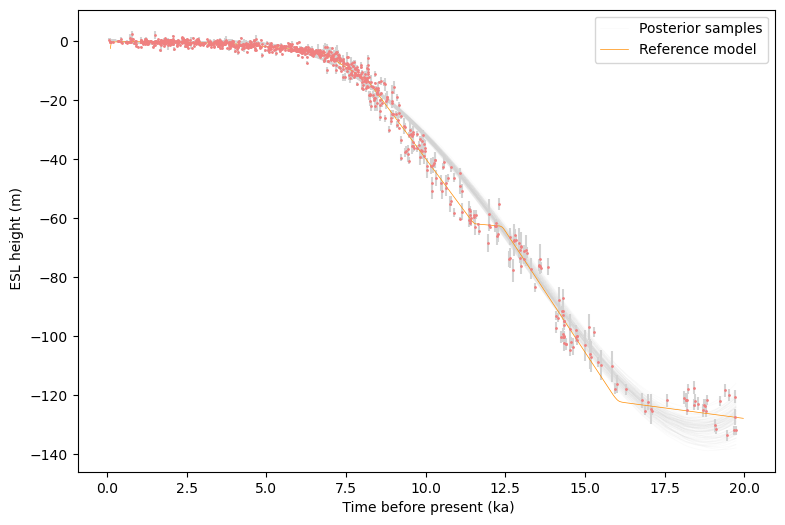

In [40]:
#@title Solution

m_lower_bound = np.array([-1.0,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([1.0,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x, ref_y, "Reference model", color="darkorange")

Is there much change to the posterior distribution?

---

## Watermark

In [41]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev25+11.gab1f820.dirty
numpy 1.21.6
scipy 1.9.1
matplotlib 3.5.3
emcee 3.1.2
arviz 0.12.1
